# Project II: Economic Growth 

This notebook will help you getting started with analyzing the growth dataset, `growth.csv`.

The code cell below has to be run to use the missingno package.

In [1]:
#pip install missingno

The code cell below has to be run to use geopandas.

In [2]:
#pip install geopandas

In [3]:
import pandas as pd 
import numpy as np 
import statsmodels.formula.api as smf
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns 
import missingno as msno
from scipy.stats import norm
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from numpy import linalg as la

## Read data 

In [4]:
dat = pd.read_csv('growth.csv')
lbldf = pd.read_csv('labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict() # as a dictionary
print(f'The data contains {dat.shape[0]} rows (countries) and {dat.shape[1]} columns (variables).')

datnames = dat.columns

The data contains 214 rows (countries) and 85 columns (variables).


# Collections of variables

In order to make the analysis simpler, it may be convenient to collect variables in sets that belong together naturally. 

In [5]:
# all available variables
vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg'] 
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference 
]
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'] # these are often missing: ['pd1', 'pop1']
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']
vv_danger = ['yellow', 'malfal',  'uvdamage']
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure  

vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources,
          'education':vv_educ
         }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]


In [6]:
# convenient to keep a column of ones in the dataset
dat['constant'] = np.ones((dat.shape[0],))

# Pre-selection of variables 

First, we subset the data to only contain the non-missing observations for gdp_initial and gdp_growth. This makes it easier to see which variables have many observations where it really matters.

In [7]:
I = dat[['gdp_growth', 'lgdp_initial']].notnull().all(axis=1)
dat_sub = dat.loc[I,:].copy()

Now plot number of observations for each category

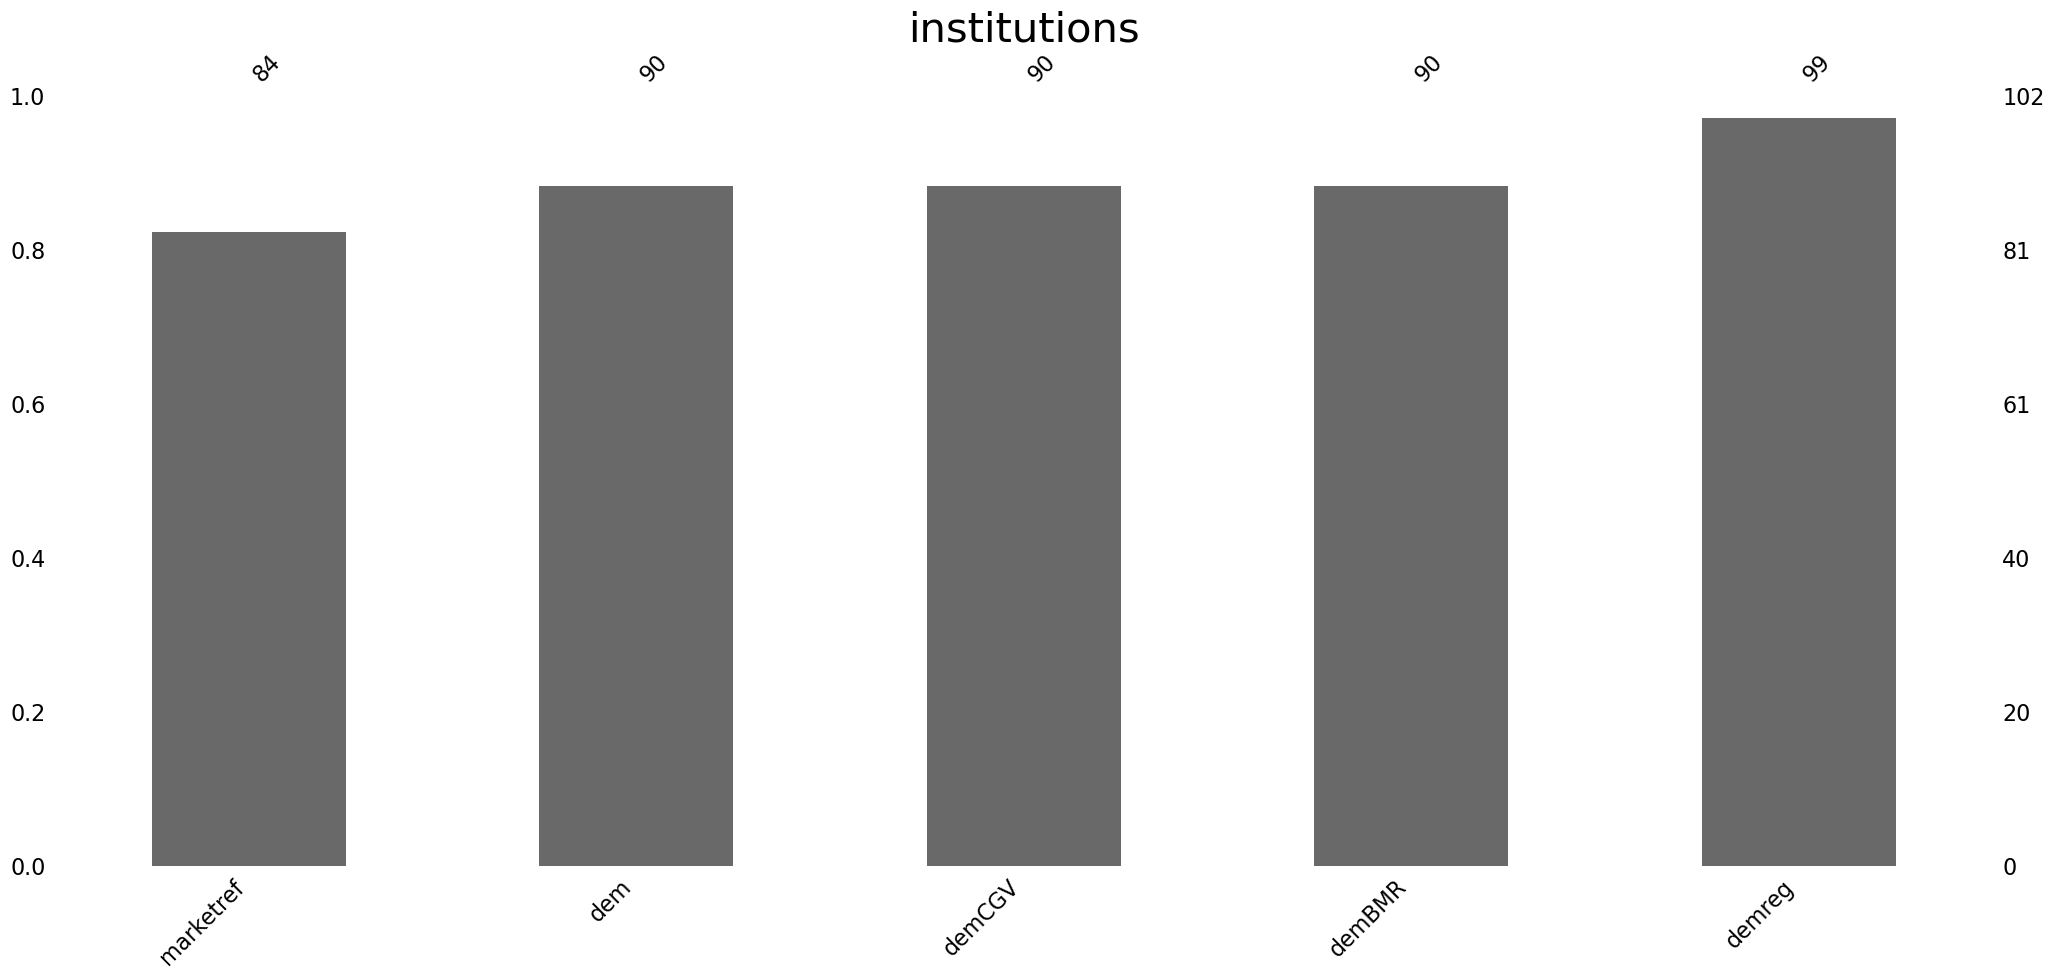

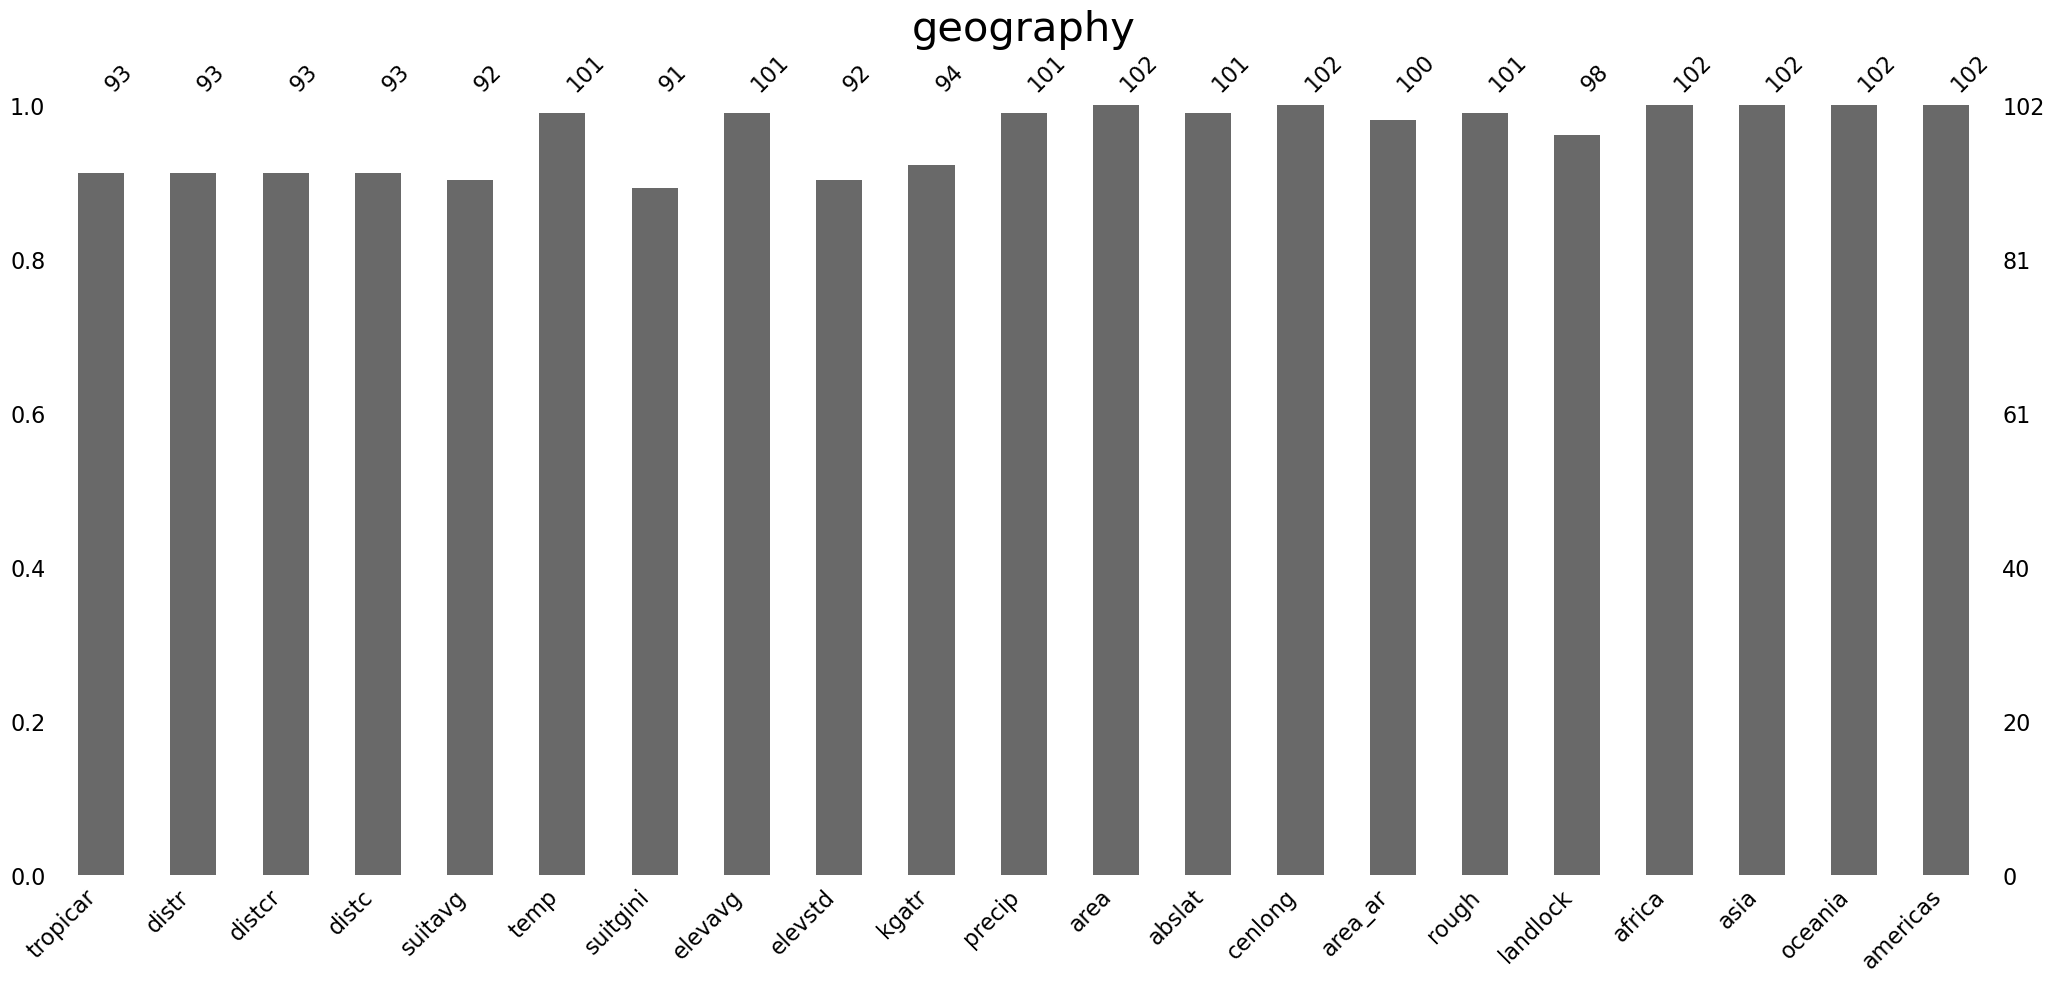

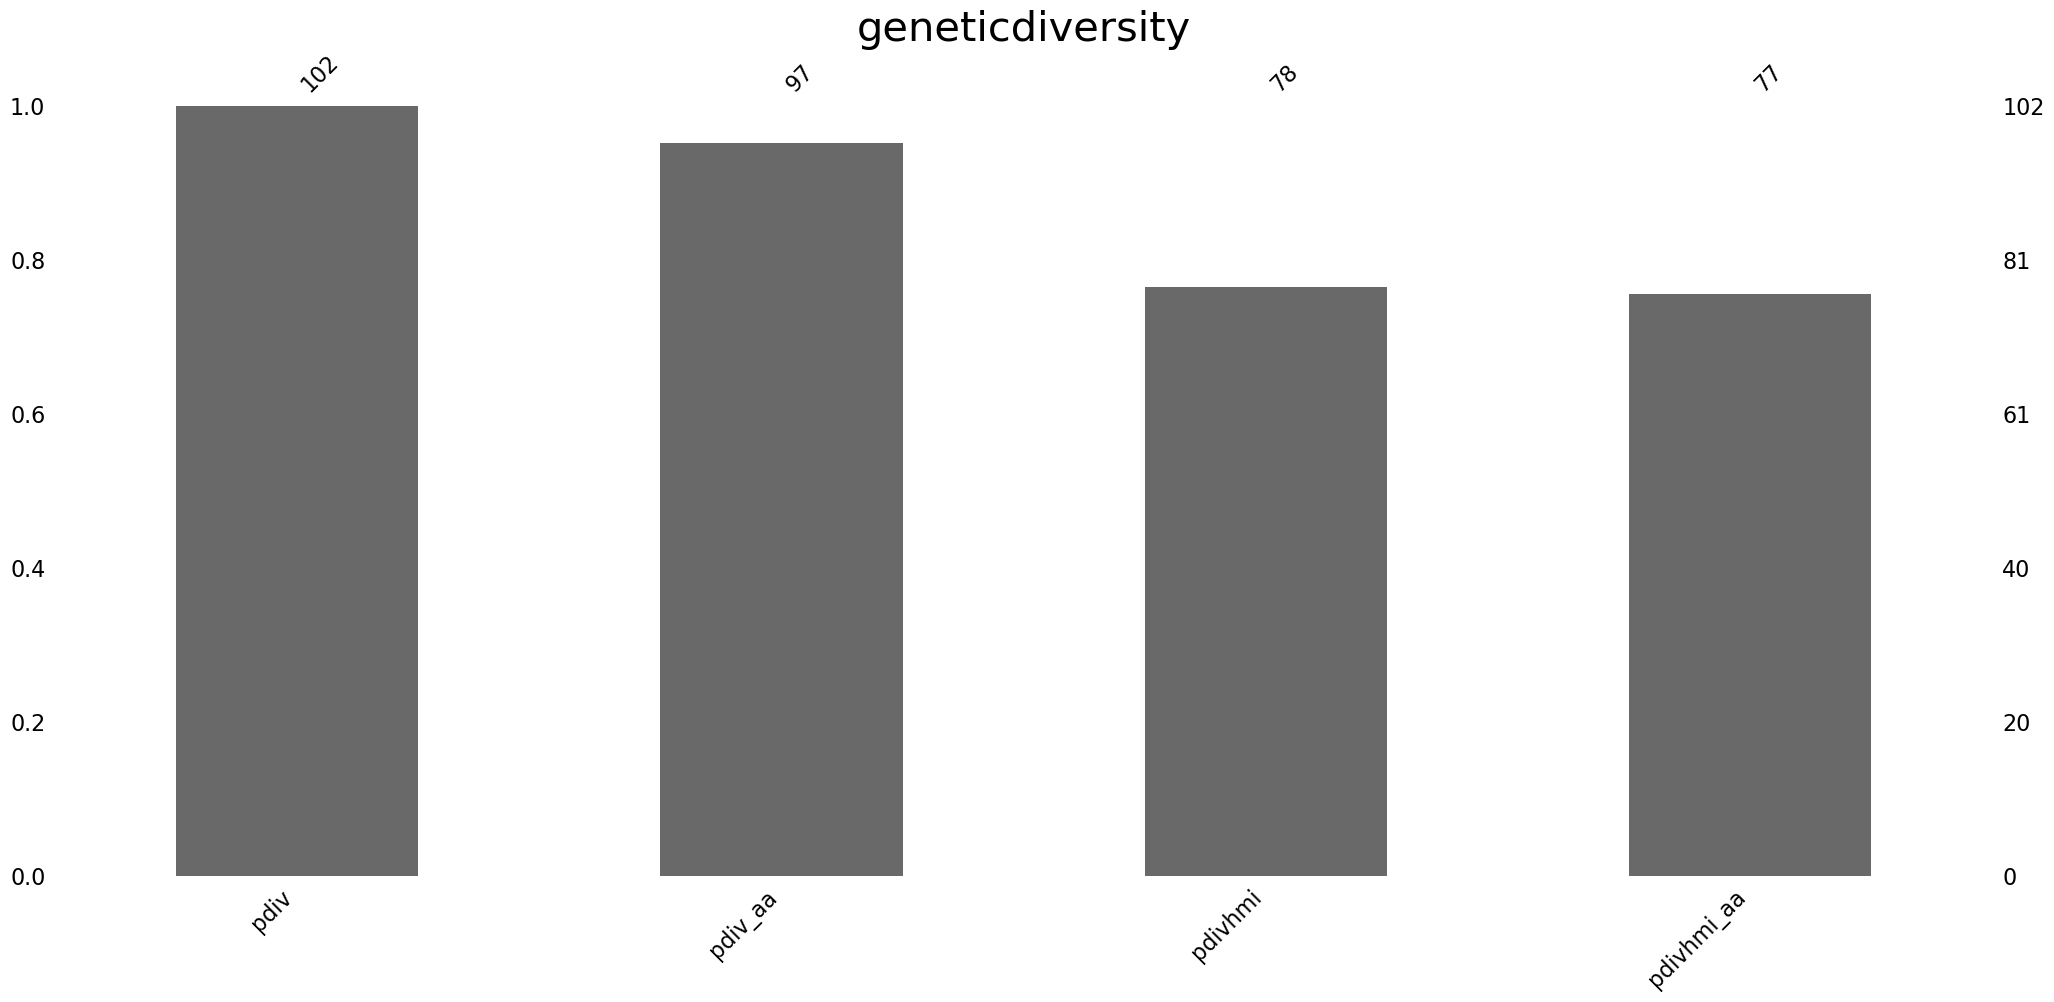

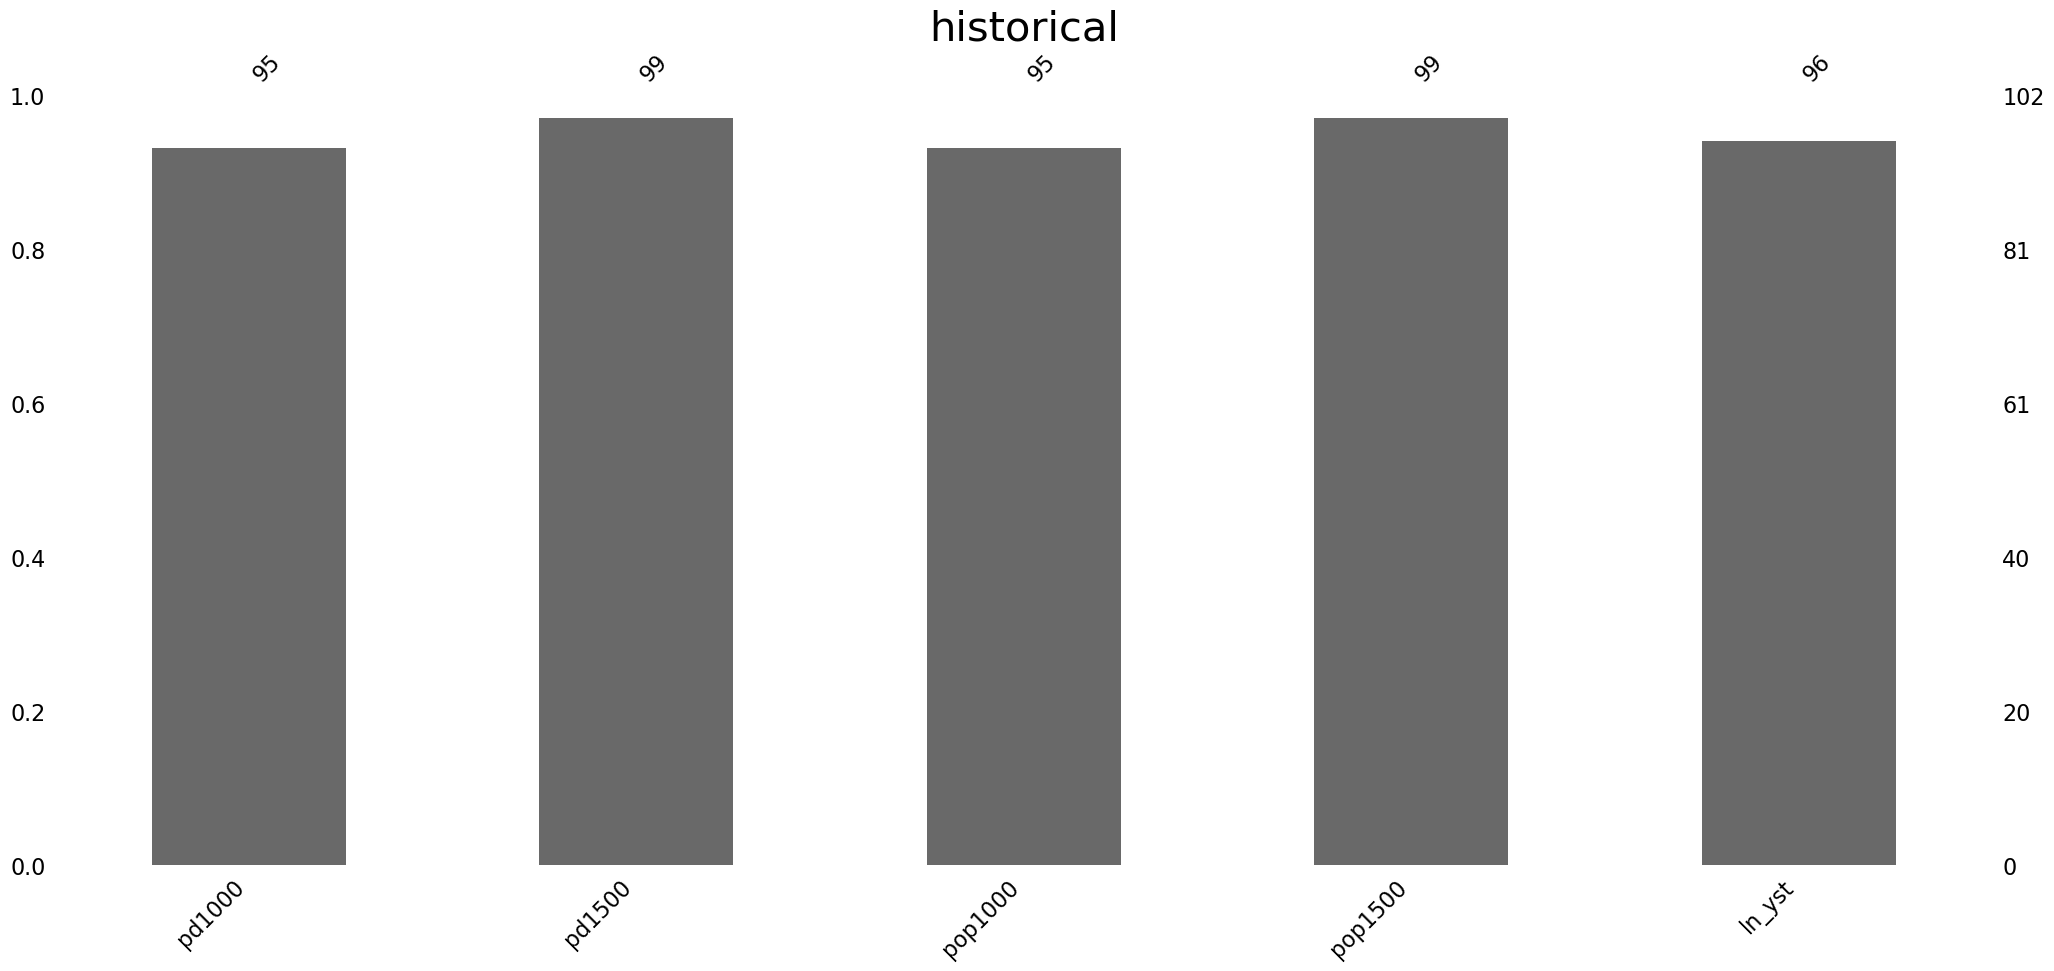

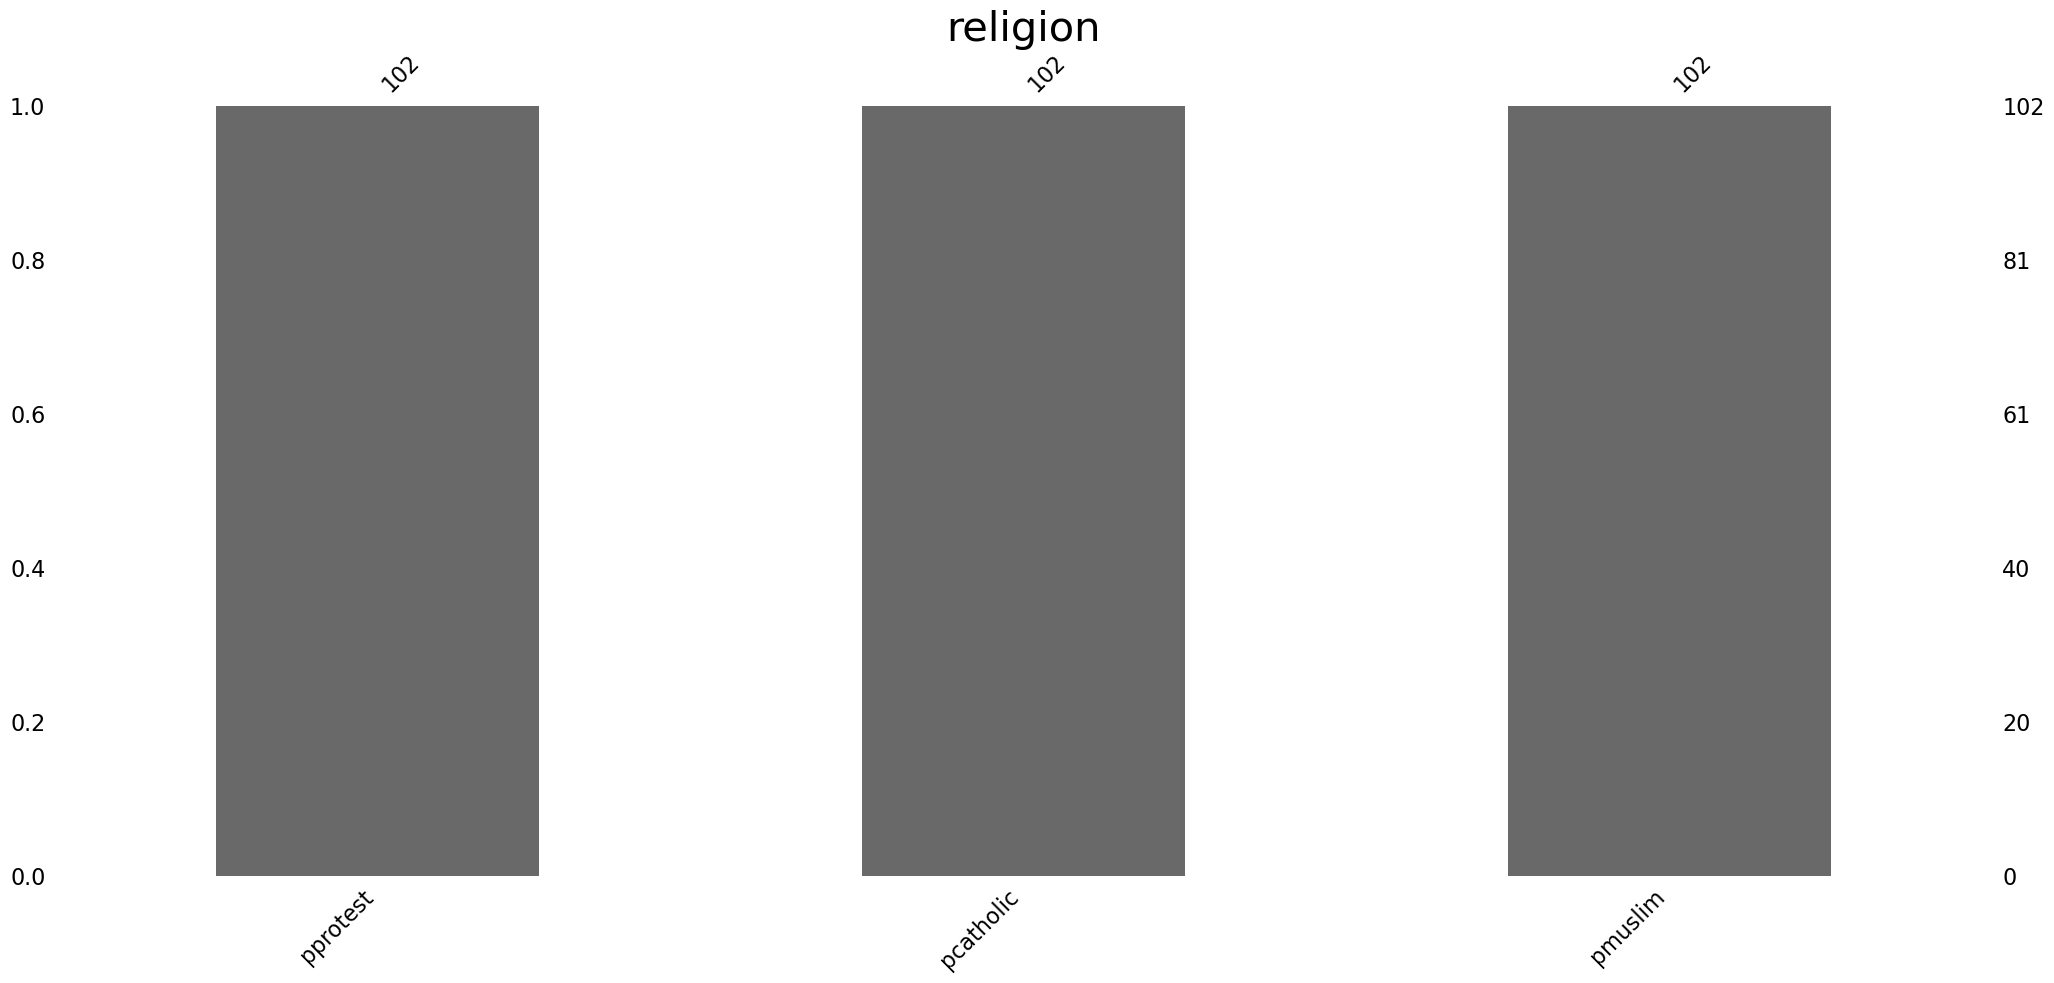

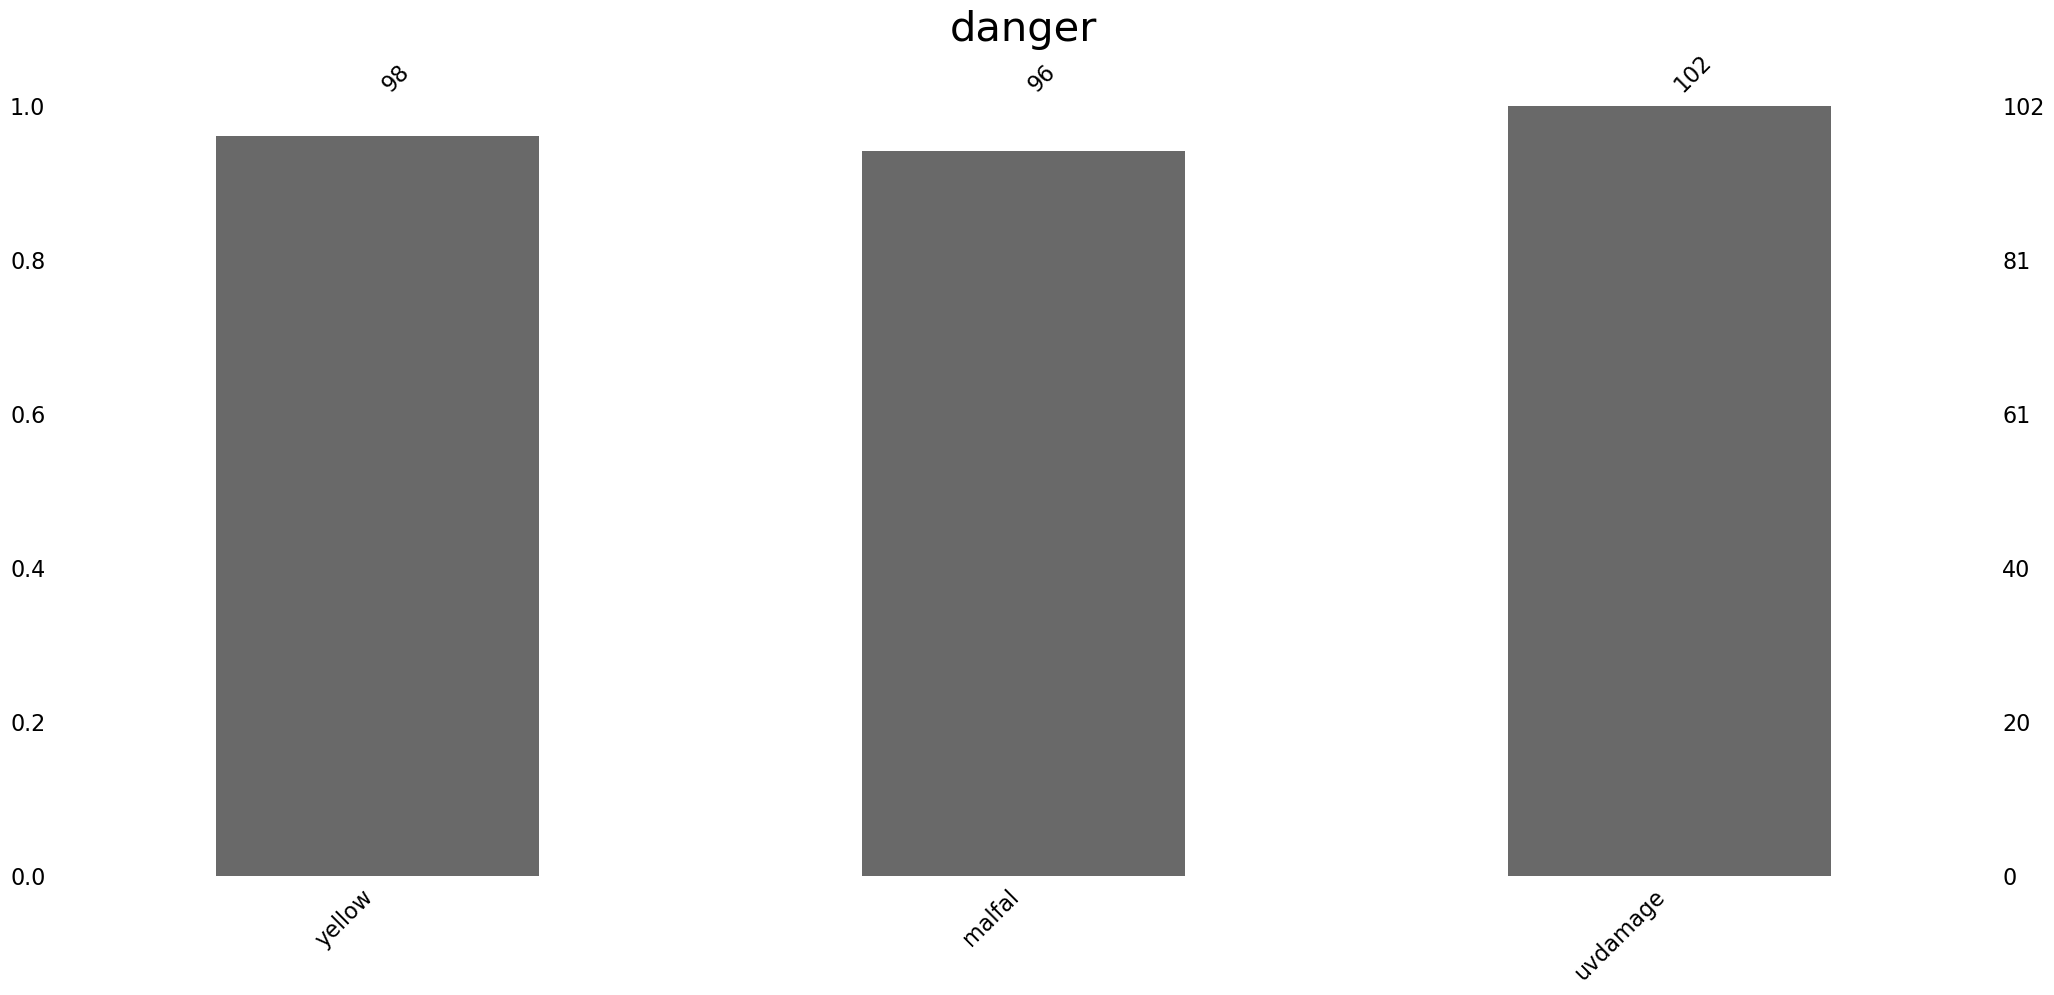

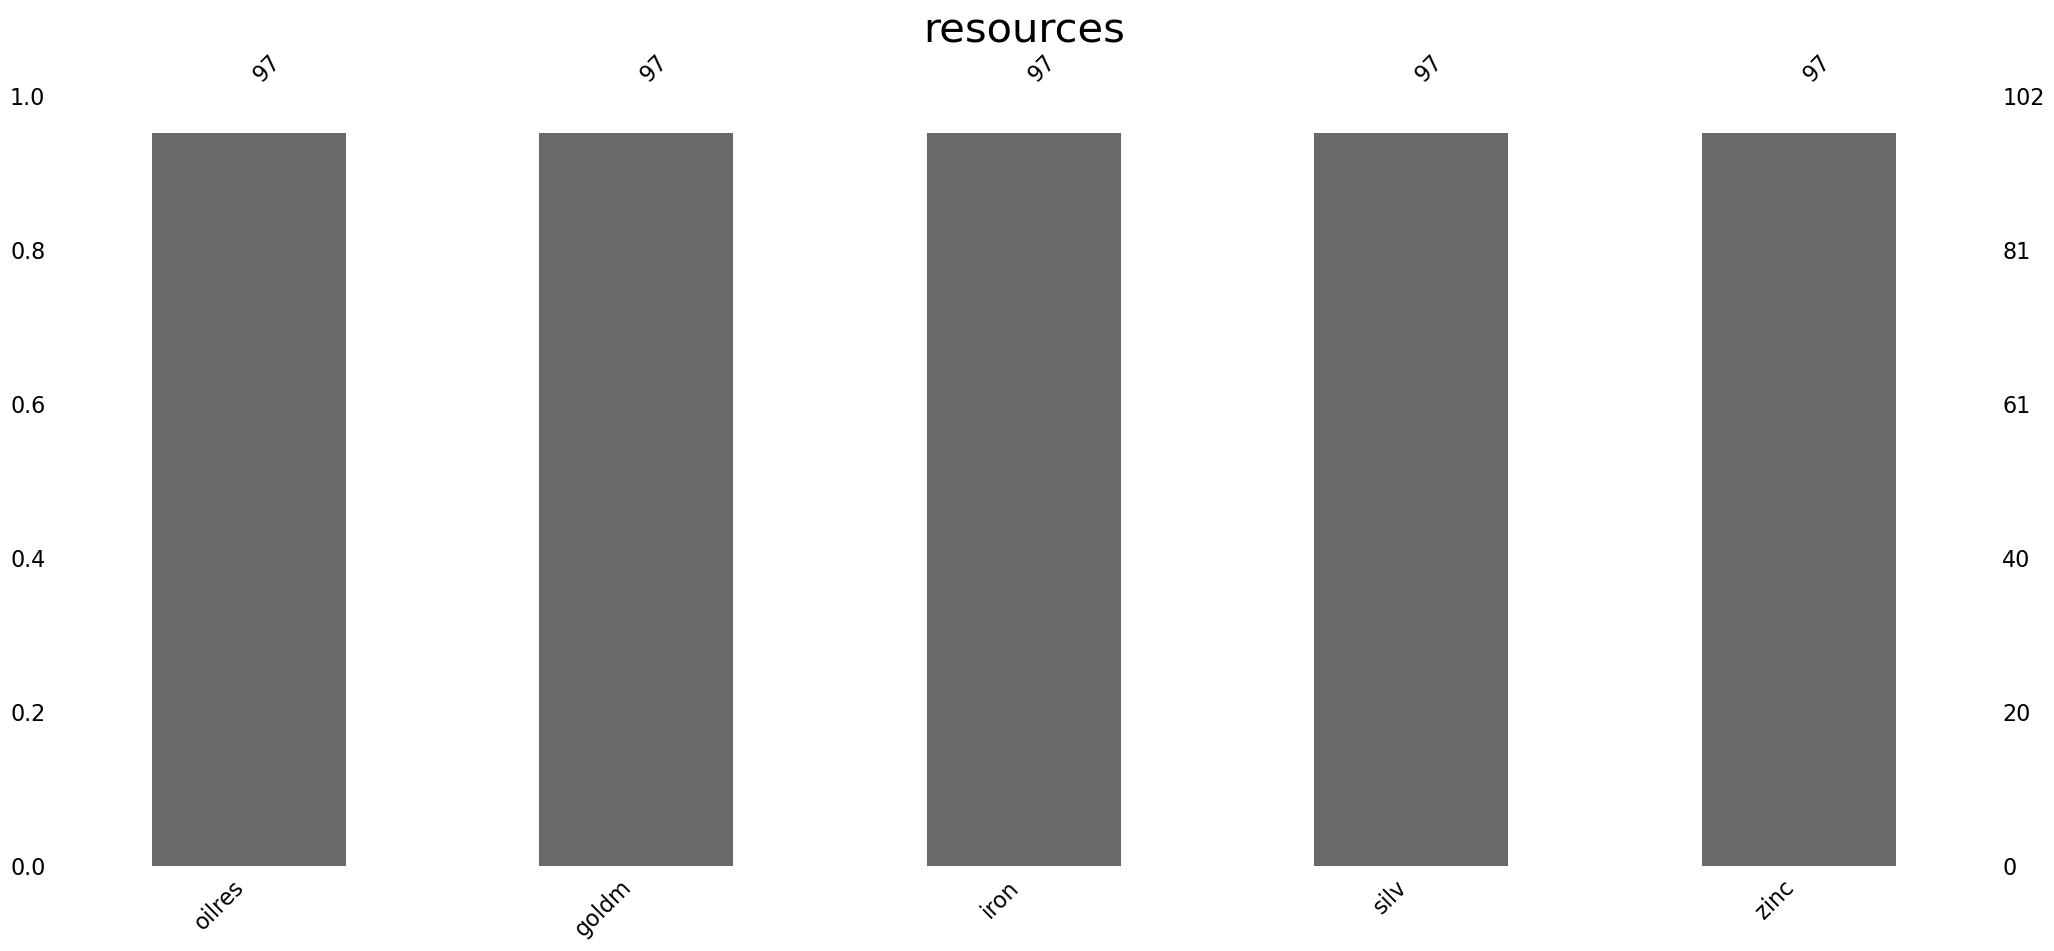

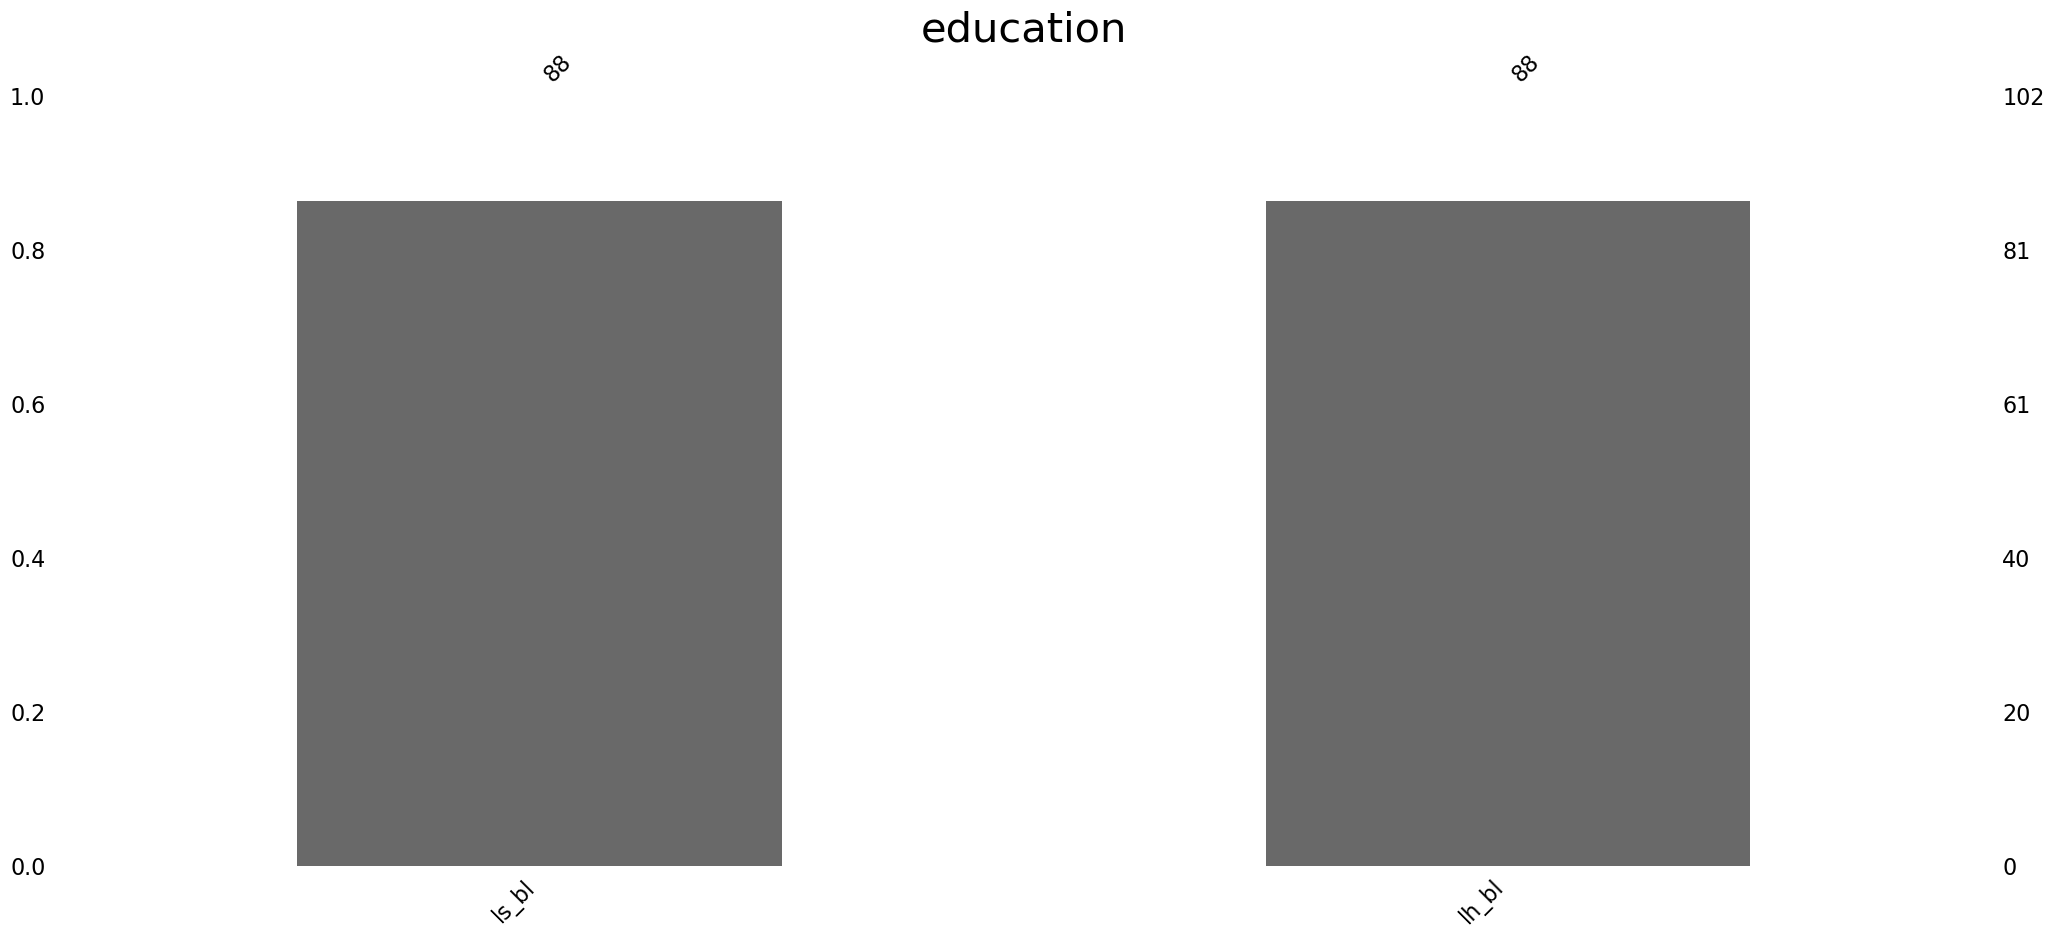

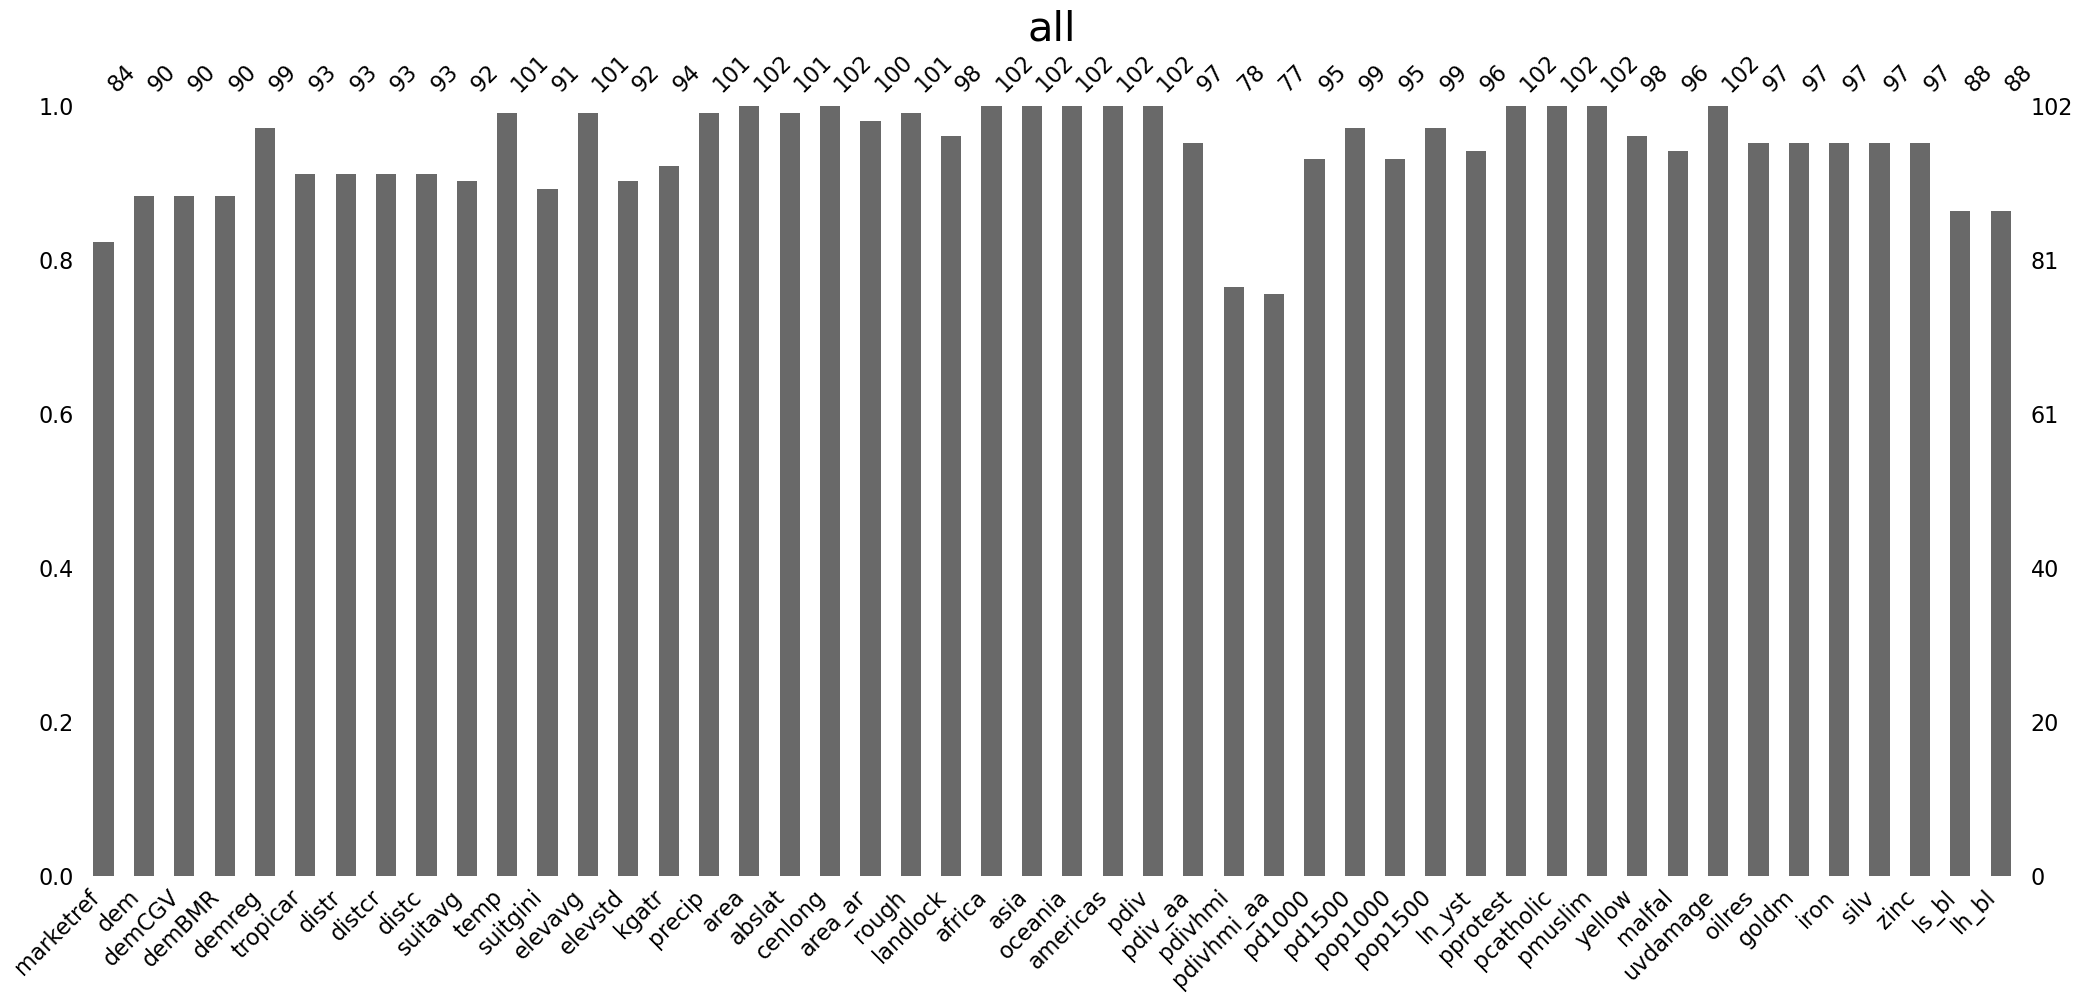

In [8]:
for key in vv_all:
    plt.figure()
    msno.bar(dat_sub[vv_all[key]])
    plt.title(key, fontsize=30)
    plt.show()

<Axes: >

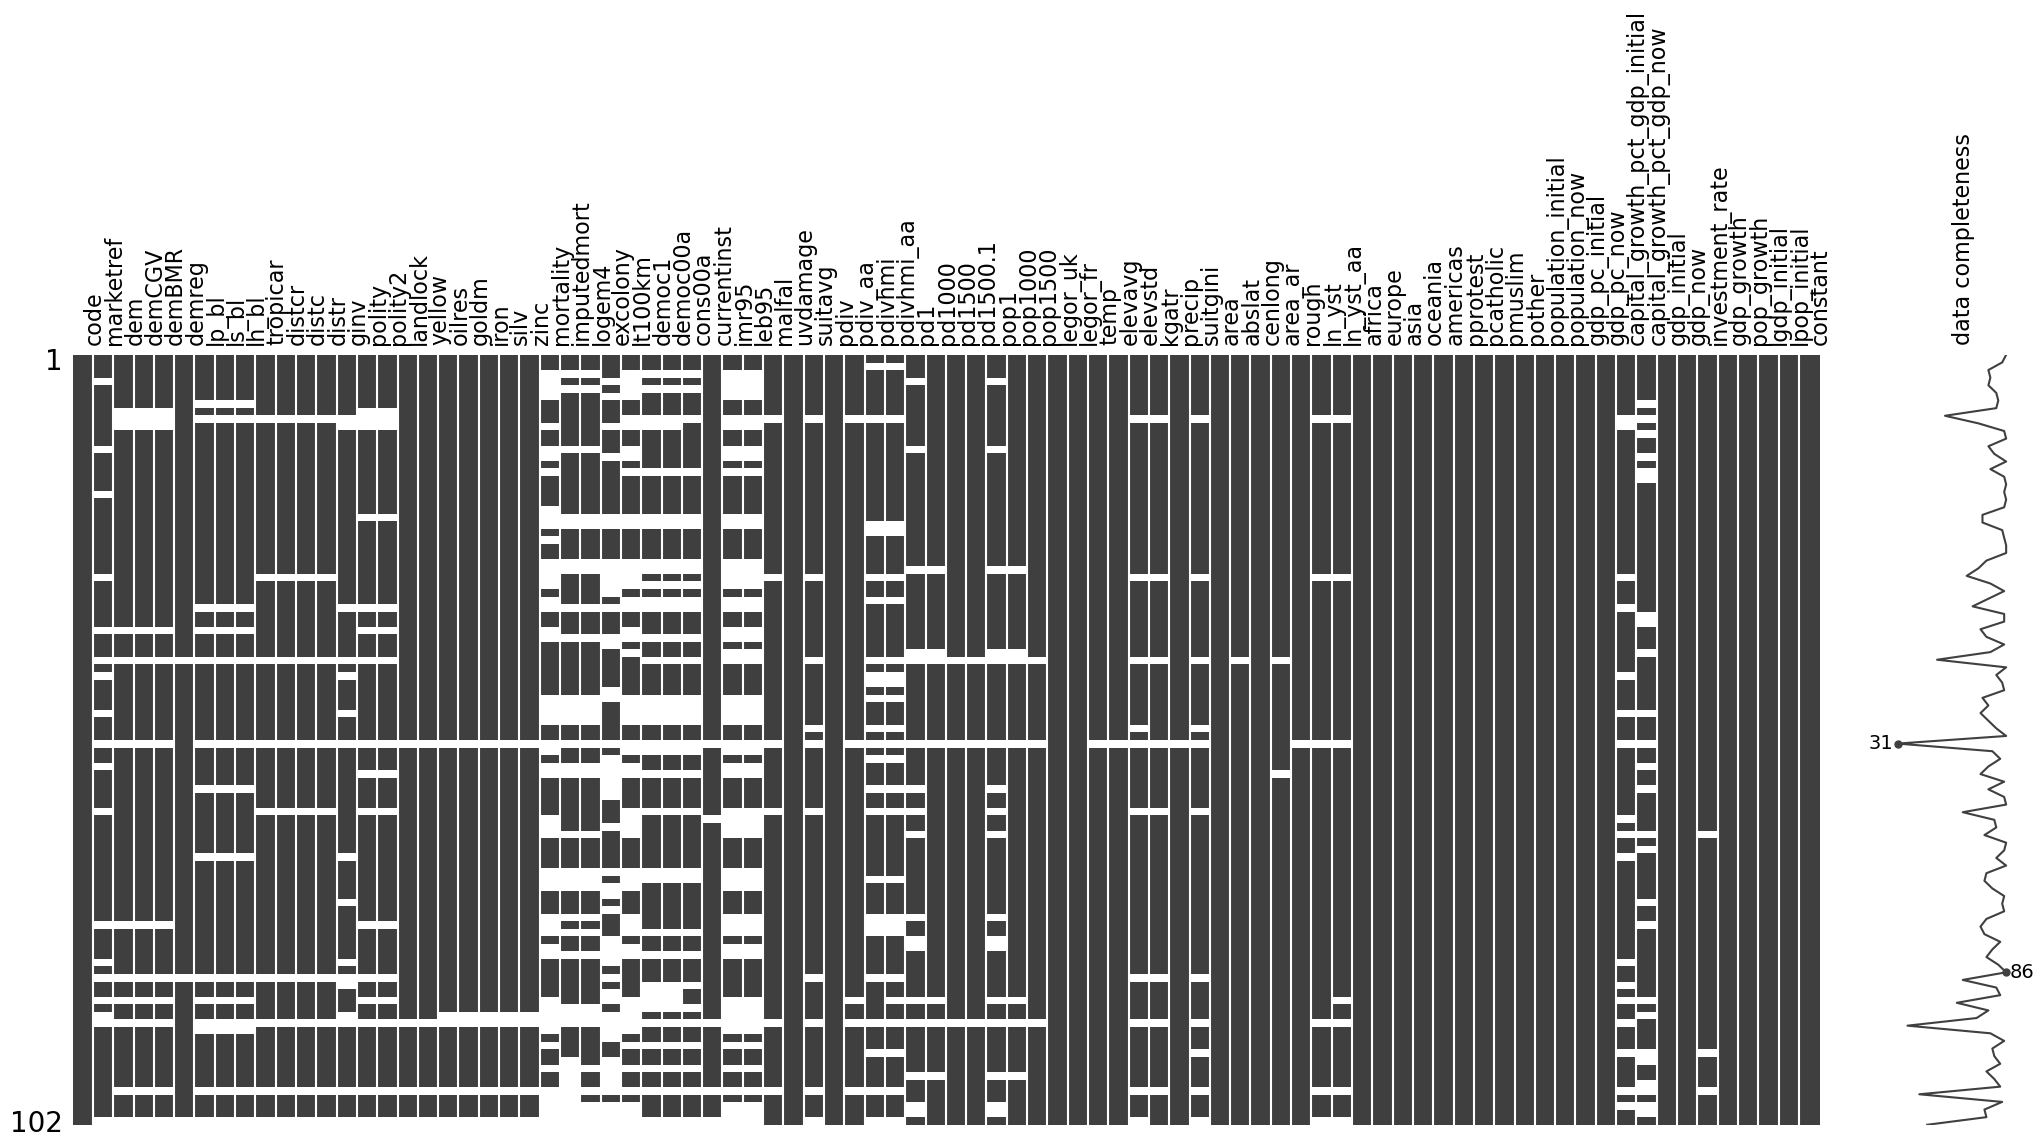

In [9]:
msno.matrix(dat_sub, labels= True, label_rotation = 90)

<Axes: >

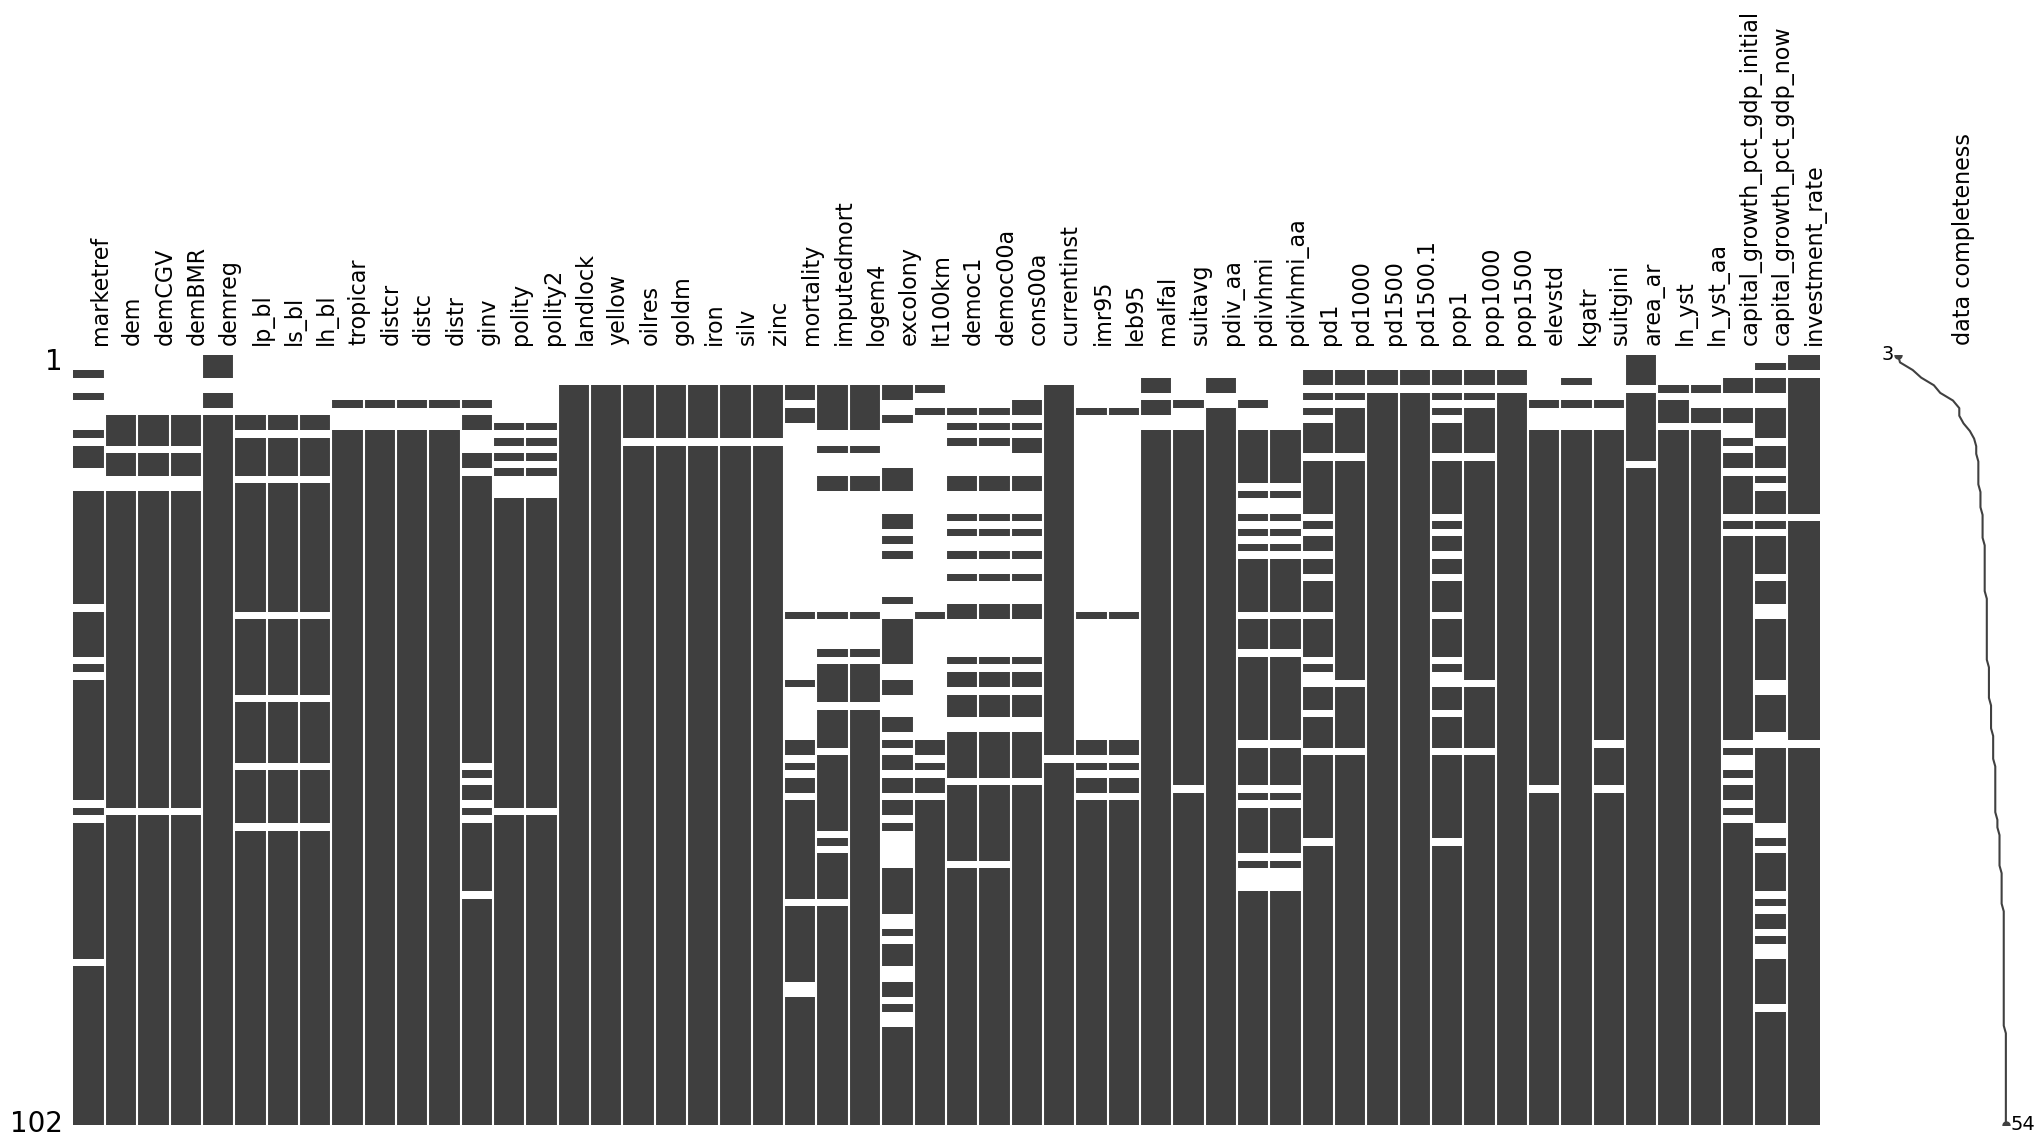

In [10]:
msno.matrix(dat_sub, labels= True,
           label_rotation = 90, 
           filter= "bottom",
           p = 0.99,
           sort='ascending')

<Axes: >

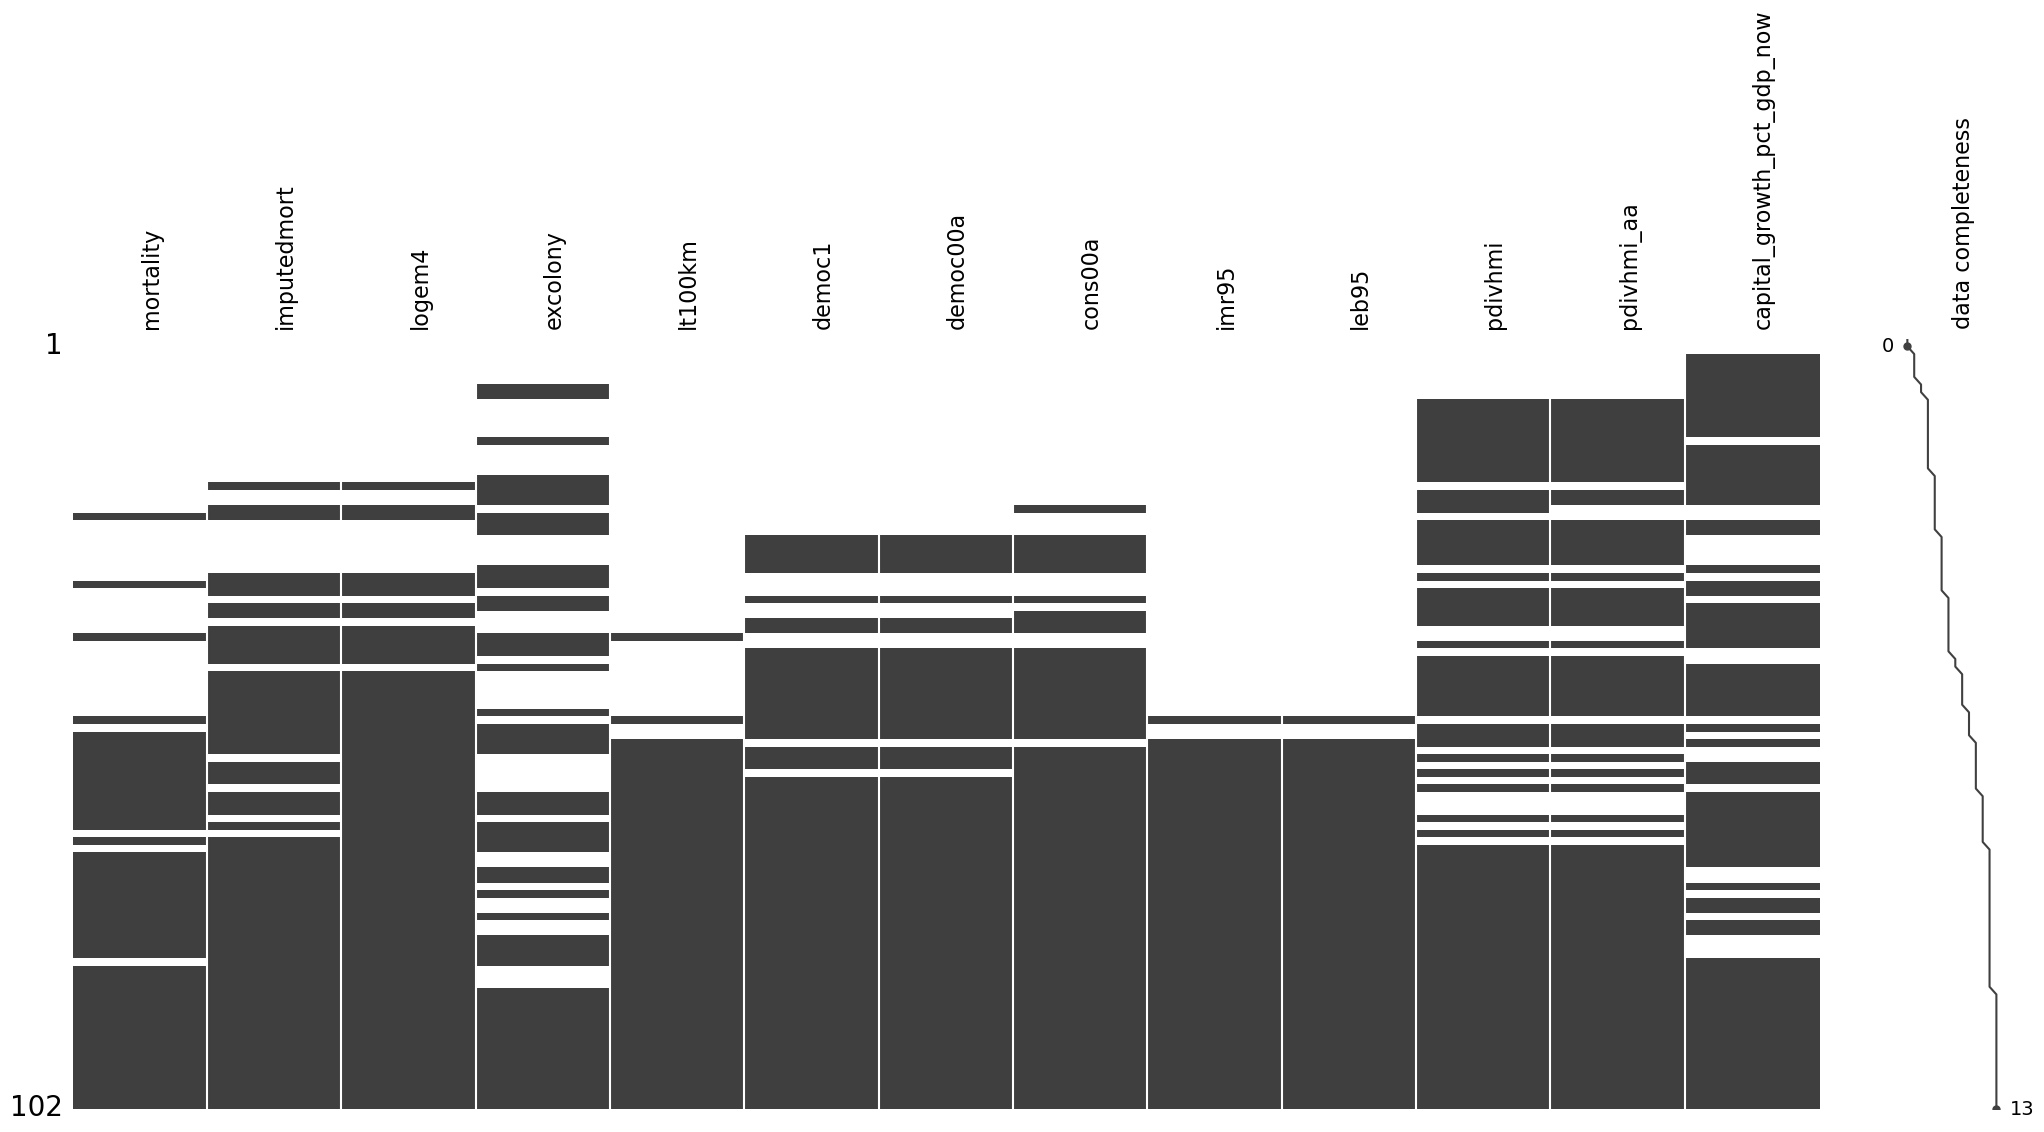

In [11]:
msno.matrix(dat_sub, labels= True,
           label_rotation = 90, 
           filter= "bottom",
           p = 0.80,
           sort='ascending')

The plot of the nullity matrix shows problems with mortality, imputedmort, and logem4. These all relate to mortality. The nullity plot indicate that logem4 dominates the rest in terms of observations. However, we exclude these variables and only include logem4 in a sensitivity analysis. (But mortality rate of what? Settlers or present day?? Check)

    logem4 is settler mortality rate, so are the other measures.

imr95 and leb95 are related concepts (infant mortality and life expextancy at birth). Both variables have considerable missing observations and all for the same variables. We can consider sensitivity analysis for subsample with these observations not missing. But we risk trading omitted variables bias for a selection bias since the countries missig these observations are not likely to be random.

    Lot of european countries with missing observations.

excolony definces whether the country is an ex-colony. There a numerous missing observations. However, the two dummies legor_fr and legor_uk indicate whether a country was a french or UK colony. These are proxies for ex-colony since UK and France. However, this largely leaves out ex-colonies in the South Americas.

    True, but maybe better with proxies than few observations. Also they are dummies, so in reference group we have South America, non-colonies, etc.

lt100 km denotes terrirory within 100 km of the coast. There are several variables with full coverage that covers this domain: distc, distcr, ditr and landlock, which indicate mean distance to coast, river and whether the coutry is landlocked.

The democracy variables cons00a, democ1 and democ00a also have several similar variables with coverage: dem, demBMR, and demCGV. Therefore we do not consider omitted variables bias from excluding cons00a, democ1 and democ00a a problem.

    Dem has the most observations, out of the pure democracy dummies, demreg has even more observations.

The variables pdivhmi and pdivhmi_aa are (ancestry adjusted) mobility index-predicted genetic diversity variables. Since we have full coverage for non-mobility index-predicted genetic diversity variables, we do not consider exclusion of pdivhmi and pdivhmi_aa  a serious problem.

    Agreed.

We exclude capital_growth_pct_gdp_no to avoid simultaneity bias.

    Agreed.

Also, we remove gdp_now and gdp_pc_now (it doesn't really make sense to adjust for GDP in 2020?)
Similary for: population_now, pop_growth. pop_growth may also be determined by be determined by initial gdp per cap.

    Agreed.




Now we set up y, d, Z and X

In [12]:
dat_drop_iter_1 = \
             dat_sub.drop(["mortality", 
             "imputedmort", 
             "logem4", 
             "imr95",
             "leb95",
             "excolony",
             "lt100km",
             "cons00a",
             "democ1",
             "democ00a",
             "pdivhmi",
             "pdivhmi_aa",
             "capital_growth_pct_gdp_now",
             "gdp_now",
             "gdp_pc_now",
             "population_now",
             "pop_growth"], axis= "columns")

dat_miss_iter1 = dat_drop_iter_1.dropna()
dat_miss_iter1.shape

(59, 69)

<Axes: >

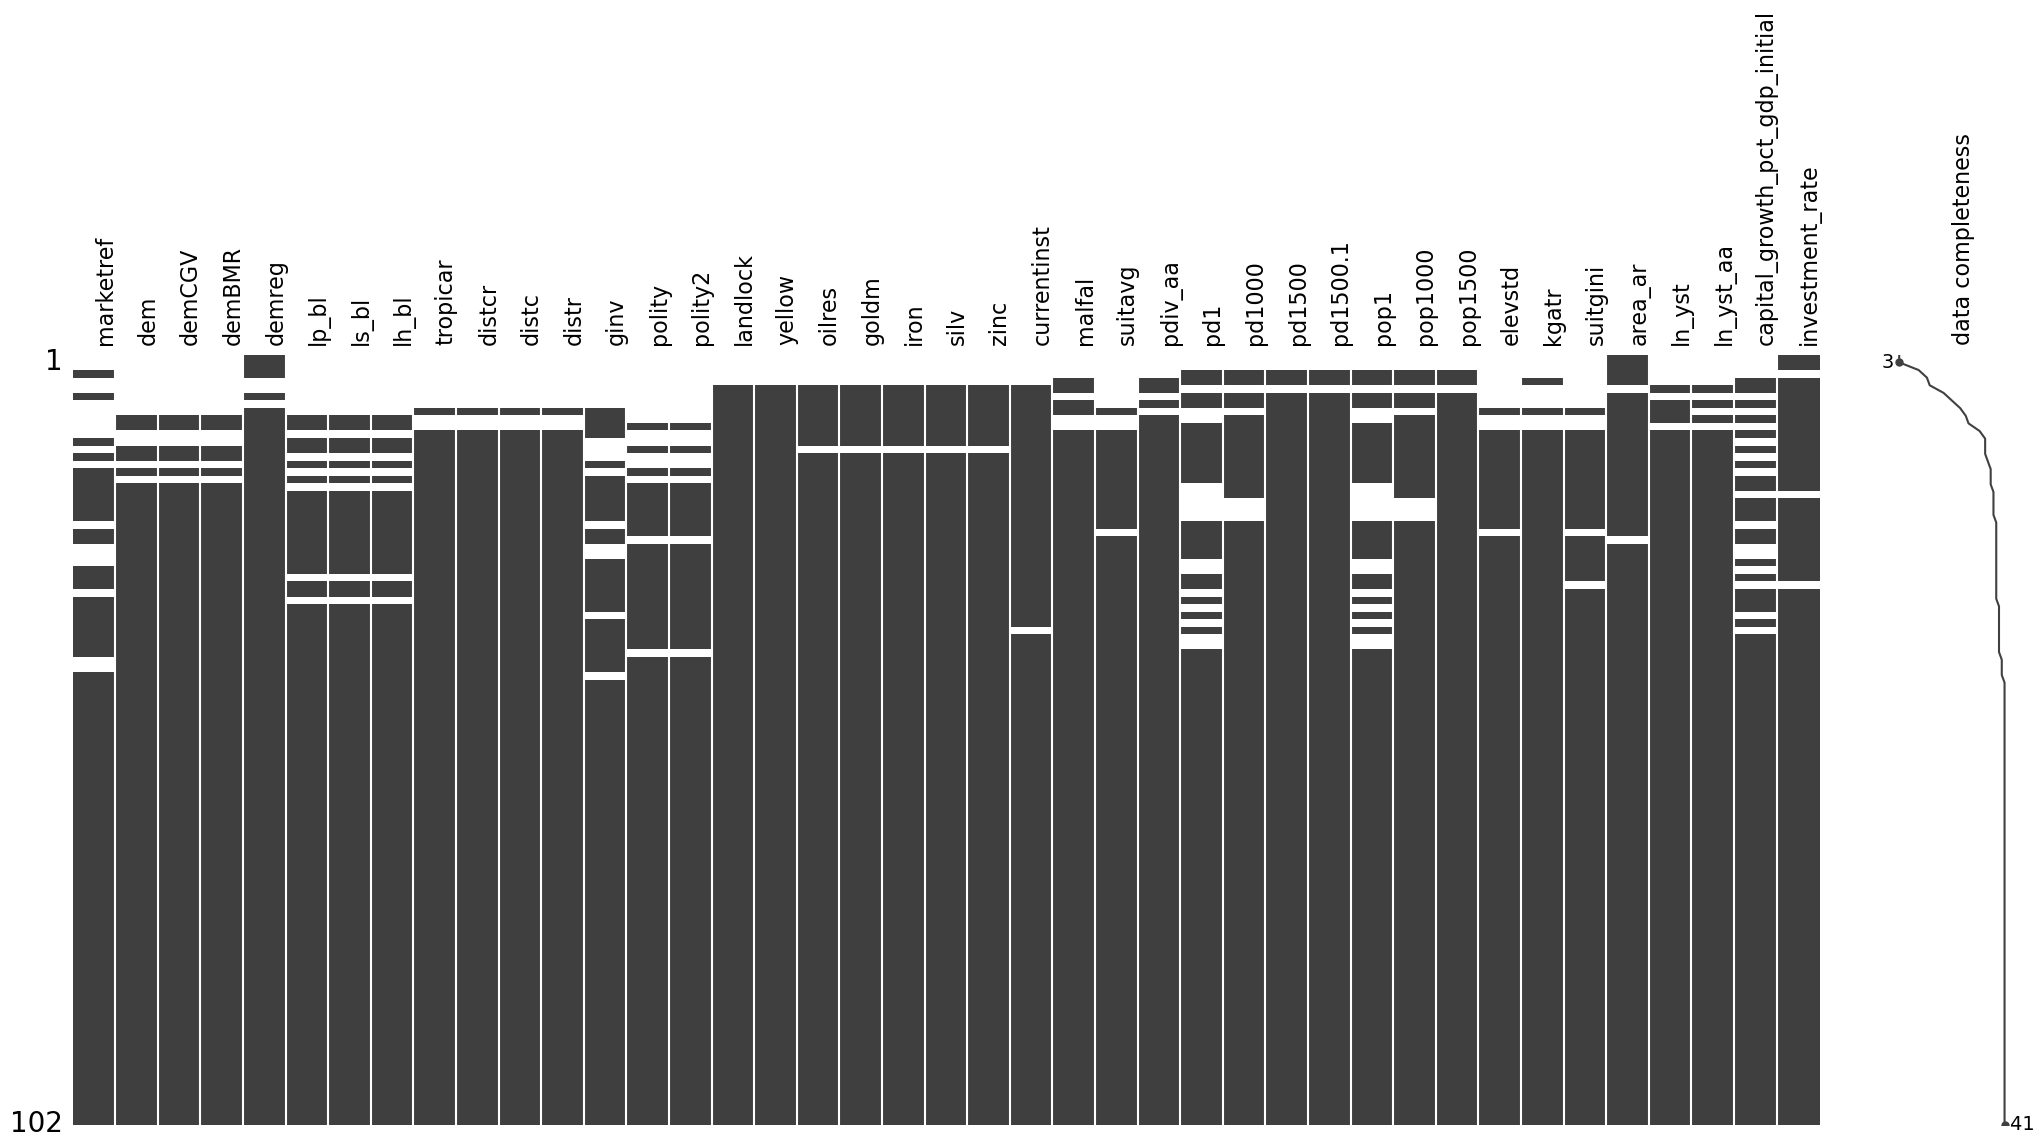

In [13]:
msno.matrix(dat_drop_iter_1,
           labels= True,
           label_rotation = 90, 
           filter= "bottom",
           p = 0.99,
           sort='ascending')

In [14]:
dat_drop_iter_2 = \
             dat_drop_iter_1.drop(
                ["pd1", # Gain: 7 obs
                 "pop1", # Gains 7 obs
                 "marketref", # Gain: 7 obs
                 "ginv", # Gain: 1 obs
                 "capital_growth_pct_gdp_initial", # 6 obs gain
                 #"polity",
                 #"polity2" # Only adds 1 obs if we remove these.
             ], axis= "columns")

dat_miss_iter2 = dat_drop_iter_2.dropna()
dat_miss_iter2.shape

(73, 64)

In [15]:

Pre_selected_vars = ['ls_bl'] +['lh_bl'] +['dem'] + ['demreg'] + ['tropicar'] \
 + ['distcr'] + ['distc'] + ['distr'] + ['landlock'] + ['yellow'] + ['oilres'] \
 + ['goldm'] + ['iron'] + ['silv'] + ['zinc'] + ['malfal'] \
 + ['uvdamage'] + ['suitavg'] + ['pdiv'] + ['pdiv_aa'] + ['pd1000'] + ['pd1500'] \
 + ['pop1000'] + ['pop1500'] + ['legor_uk'] + ['legor_fr'] \
 + ['temp'] + ['elevavg'] + ['elevstd'] + ['kgatr'] + ['precip'] + ['suitgini'] \
 + ['area'] + ['abslat'] + ['cenlong'] + ['area_ar'] + ['rough'] + ['ln_yst'] \
 + ['ln_yst_aa'] + ['africa'] + ['asia'] + ['oceania'] + ['americas'] + \
 ['pprotest'] + ['pcatholic'] + ['pmuslim'] + ['lpop_initial']

sensitivity_vars = Pre_selected_vars + ['imr95'] + ['leb95']


In [46]:

vs = Pre_selected_vars 
#vs = sensitivity_vars #should be uncommented if we want to run the sensitivity analysis
zs = ['pop_growth', 'investment_rate'] + vs
xs = ['lgdp_initial'] + zs #our target is index

# avoiding missings
all_vars = ['gdp_growth'] + xs
I = dat[all_vars].notnull().all(1)

# extract data
y = dat.loc[I,'gdp_growth'].values.reshape((-1,1)) * 100. #easier to read output when growth is in 100%
d = dat.loc[I, 'lgdp_initial'].values.reshape((-1,1))
Z = dat.loc[I, zs].values
X = dat.loc[I, xs].values


Find number of observations

In [48]:
print(f'Number of observations: {y.shape[0]}')

Number of observations: 75


['ARG', 'AUS', 'AUT', 'BDI', 'BEL', 'BEN', 'BOL', 'BRA', 'BWA', 'CAF', 'CHL', 'CHN', 'CIV', 'CMR', 'COG', 'COL', 'CRI', 'DEU', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'FRA', 'GAB', 'GBR', 'GHA', 'GMB', 'GRC', 'GTM', 'HND', 'HTI', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 'ITA', 'KEN', 'KOR', 'LKA', 'LSO', 'MAR', 'MEX', 'MLI', 'MMR', 'MRT', 'MYS', 'NER', 'NIC', 'NLD', 'NOR', 'NPL', 'PAK', 'PAN', 'PER', 'PHL', 'PRT', 'PRY', 'RWA', 'SAU', 'SDN', 'SEN', 'SLE', 'SLV', 'SWE', 'TGO', 'THA', 'TUN', 'TUR', 'USA', 'ZAF', 'ZMB', 'ZWE']


C:\Users\Bruger\AppData\Local\Temp\ipykernel_17224\1408889593.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


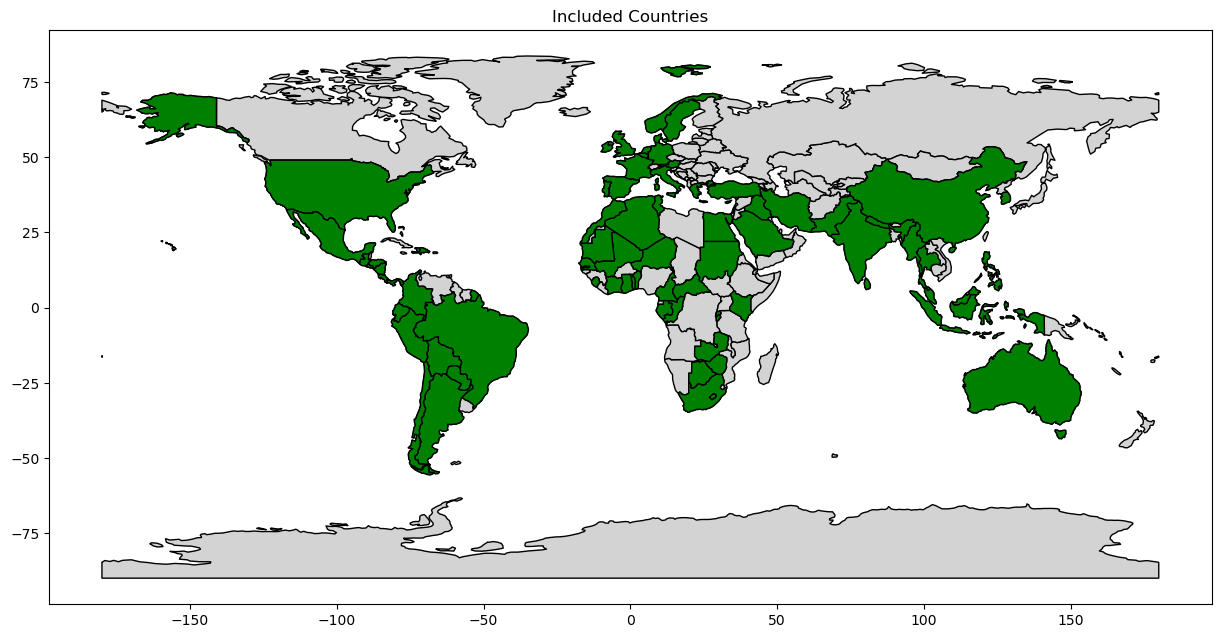

In [49]:
countries_with_no_missing_values = dat[I]['code'].tolist()
print(countries_with_no_missing_values)

# Load the world map dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter the world dataset to only include countries in your list using the iso_a3 column
highlighted_countries = world[world['iso_a3'].isin(countries_with_no_missing_values)]
ax = world.plot(color='lightgrey', edgecolor='black', figsize=(15, 10))
highlighted_countries.plot(ax=ax, color='green', edgecolor='black')
plt.title("Included Countries")
plt.show()

# OLS

In [50]:
dat['constant'] = np.ones((dat.shape[0],))

In [51]:
# 1. avoiding missings 
I_OLS = dat[['gdp_growth', 'lgdp_initial']].notnull().all(axis=1)

# add const. (unless this breaks the rank condition)
X_ols = dat.loc[I_OLS, ['constant','lgdp_initial']].values
y_ols = dat.loc[I_OLS, 'gdp_growth'].values.reshape((-1,1)) *100

# check the rank condition
K = X_ols.shape[1]
assert np.linalg.matrix_rank(X_ols) == X_ols.shape[1], f'X does not have full rank'

# compute the OLS estimator
betas_ols = np.linalg.inv(X_ols.T @ X_ols) @ X_ols.T @ y_ols

# compute residuals
res_ols = y_ols - X_ols @ betas_ols

# function to compute the variance-covariance matrix and standard errors
def robust( x: np.array, residual: np.array) -> tuple:
 
    # If only cross sectional, we can easily use the diagonal.
    Ainv = la.inv(x.T@x)
    uhat2 = residual ** 2
    uhat2_x = uhat2 * x # elementwise multiplication: avoids forming the diagonal matrix (RAM intensive!)
    cov = Ainv @ (x.T@uhat2_x) @ Ainv
    se = np.sqrt(np.diag(cov)).reshape(-1, 1)
    return cov, se

# compute the variance-covariance matrix and standard errors
cov_ols, se_ols = robust(X_ols, res_ols)

# compute confidence intervals
q = norm.ppf(0.975)

# Calculate confidence interval
CI_low_OLS  = (betas_ols[1]-q*se_ols[1])[0]
CI_high_OLS = (betas_ols[1]+q*se_ols[1])[0]

# Display confidence interval
print("OLS Regression Results", betas_ols[1][0].round(3))
print("CI_OLS = ",(CI_low_OLS.round(2),CI_high_OLS.round(2)))


OLS Regression Results -0.087
CI_OLS =  (-0.3, 0.13)


# Post-double Lasso

Standardize

In [52]:
def standardize(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    X_stan = (X - mu)/sigma
    return X_stan


# Standardize data
X_stan = standardize(X)
Z_stan = standardize(Z)
d_stan = standardize(d)

Check shape

In [53]:
print(f"y.shape = {y.shape}, X_stan.shape = {X_stan.shape}, Z_stan.shape = {Z_stan.shape}, d_stan.shape = {d_stan.shape}")


y.shape = (75, 1), X_stan.shape = (75, 52), Z_stan.shape = (75, 51), d_stan.shape = (75, 1)


Define function for BCCH penalty

In [54]:
def BCCH_penalty(x,y):
    # BCCH pilot penalty
    n,p = x.shape
    c = 1.1
    alpha = 0.05
    yx_scale = (np.max((x.T ** 2) @ ((y-np.mean(y)) ** 2) / n)) ** 0.5
    penalty_pilot = c / np.sqrt(n) * norm.ppf(1-alpha/(2*p)) * yx_scale

    # Pilot estimates
    #Create predicted value using Lasso 
    pred = Lasso(alpha=penalty_pilot).fit(x,y).predict(x)

    # Updated penalty
    eps = y - pred 
    eps_x_scale = (np.max((x.T ** 2) @ (eps ** 2) / n)) ** 0.5
    penalty = c*norm.ppf(1-alpha/(2*p))*eps_x_scale/np.sqrt(n)

    return penalty

Penalty for y on X

In [55]:
penalty_yX = BCCH_penalty(X_stan,y)

Now we run Lasso of Y on d and Z

In [56]:
#Run Lasso
fit_BCCH_yx = Lasso(alpha=penalty_yX, max_iter=10000).fit(X_stan,y)
coefs_y = fit_BCCH_yx.coef_

# Calculate residuals
res_yx = y - fit_BCCH_yx.predict(X_stan).reshape(-1,1)

# Calculate Y - Z@gamma (epsilon + alpha*d)
res_yz = y - Z_stan@np.array(coefs_y[1:]).reshape(-1,1)


See what variables were selected

In [57]:
# Investigate the coefficients

print('Coefficients: ', np.round(coefs_y ,5))

# Investigate the selected variables
selected_variables = (coefs_y!=0)
print('Selected varriables: ', selected_variables) 

Coefficients:  [-0. -0.  0.  0.  0.  0.  0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0.  0.
 -0. -0.  0. -0. -0.  0.  0.  0.  0.  0.  0. -0. -0.  0.  0. -0.  0. -0.
  0.  0.  0.  0.  0.  0.  0. -0.  0. -0. -0. -0. -0. -0.  0.  0.]
Selected varriables:  [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]


Penalty for d on Z

In [58]:
penalty_dZ = BCCH_penalty(Z_stan,d)
penalty_dZ

1.0057594528291876

Now running Lasso of d on Z

In [59]:
# Run Lasso
fit_BCCH_dz = Lasso(alpha=penalty_dZ,max_iter=10000).fit(Z_stan,d)
coefs_d=fit_BCCH_dz.coef_

# Calculate residuals
res_dz=d-fit_BCCH_dz.predict(Z_stan).reshape(-1,1)
print(coefs_d)

[-0.         0.         0.         0.         0.         0.
 -0.        -0.        -0.        -0.        -0.        -0.
  0.         0.         0.         0.         0.        -0.
 -0.0098071  0.        -0.        -0.         0.         0.
  0.        -0.        -0.        -0.         0.        -0.
 -0.        -0.        -0.        -0.         0.         0.
  0.        -0.        -0.        -0.         0.         0.
 -0.        -0.         0.         0.         0.         0.
 -0.        -0.         0.       ]


Calculate alpha

In [60]:
# Calculate alpha
num = res_dz.T@res_yz
denom = res_dz.T@d
alpha_PDL = np.array(num/denom)[0][0]

# Display alpha
print("alpha_PDL = ",alpha_PDL.round(2))

alpha_PDL =  -0.17


Calculate implied variance estimate

In [61]:
N = X.shape[0]

In [62]:
# Calculate variance    
res_yx_sq = np.square(res_yx)
res_dz_sq = np.square(res_dz)

num = np.zeros((1,1))
for i in range(N):
    num += res_yx_sq[i]*res_dz_sq[i]
num = num/N

denom = (np.sum(res_dz_sq)/N)**2

sigma2_PDL=(num/denom)[0][0]

# Display variance
print("sigma2_PDL = ",sigma2_PDL.round(2))

sigma2_PDL =  1.39


And standard error

In [63]:
# Calculate standard error
se_PDL = np.sqrt(sigma2_PDL/N)

# Display standard error
print("se_PDL = ",se_PDL.round(2))

se_PDL =  0.14


Confidence interval

In [64]:
# Calculate the quantile of the standard normal distribution that corresponds to the 95% confidence interval of a two-sided test
q = norm.ppf(0.975)

# Calculate confidence interval
CI_low_PDL  = alpha_PDL-q*se_PDL
CI_high_PDL = alpha_PDL+q*se_PDL

# Display confidence interval
print("CI_PDL = ",(CI_low_PDL.round(2),CI_high_PDL.round(2)))

CI_PDL =  (-0.44, 0.1)


Now we try a cross validaiton approach

In [65]:
#create a grid of penalty values using the numpy function geomspace
penalty_grid = np.geomspace(0.01,80000, num=50)

In [77]:
#cv wants a 1d y array
y=y.ravel()

In [79]:
# Estimate the model using LassoCV
fit_CV = LassoCV(cv = 5, alphas=penalty_grid).fit(X_stan,y)

In [80]:
# Investigate the penalty
fit_CV = LassoCV(cv = 5, alphas=penalty_grid).fit(X_stan,y)


penalties_CV = fit_CV.alphas_

MSE_CV = np.mean(fit_CV.mse_path_, axis=1)

MSE_std = np.std(fit_CV.mse_path_, axis=1)

MSE_SE = MSE_std/np.sqrt(5)

 

min_MSE_idx = np.argmin(MSE_CV)

MSE_MIN_CV_SE = MSE_CV[min_MSE_idx] + MSE_SE[min_MSE_idx]

MSE_CV_SE = MSE_CV[MSE_CV > MSE_MIN_CV_SE]

min_MSE_SE_idx = np.argmin(MSE_CV_SE)

lamb1 = penalty_grid[MSE_CV.shape[0] - np.argmin(MSE_CV_SE) - 1]

 

min_MSE_penalty = penalty_grid[min_MSE_idx]

min_MSE_SE = MSE_SE[min_MSE_idx]


print('Penalty_CV: ', round(lamb1,4))

Penalty_CV:  0.134


In [81]:
fit_CV_yx = Lasso(alpha=lamb1,  max_iter=10000).fit(X_stan,y)
print(fit_CV_yx.coef_)

res_cv_yx = fit_CV_yx.predict(X_stan).reshape(-1,1)


[-0.38822828 -0.21111113  0.23608946  0.          0.          0.10165784
  0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.01608679 -0.         -0.          0.
 -0.40900967 -0.          0.         -0.         -0.02671193  0.
  0.          0.          0.          0.18086606 -0.         -0.05029683
 -0.         -0.         -0.         -0.          0.         -0.
  0.          0.          0.10417341  0.         -0.          0.
  0.         -0.          0.19013951 -0.          0.         -0.
  0.         -0.          0.14894882  0.        ]


In [82]:
# Retrieve penalty and MSE

penalties_CV = fit_CV.alphas_

MSE_CV = np.mean(fit_CV.mse_path_, axis=1)

MSE_std = np.std(fit_CV.mse_path_, axis=1)

MSE_SE = MSE_std/np.sqrt(5)

 

min_MSE_idx = np.argmin(MSE_CV)

MSE_MIN_CV_SE = MSE_CV[min_MSE_idx] + MSE_SE[min_MSE_idx]

MSE_CV_SE = MSE_CV[MSE_CV > MSE_MIN_CV_SE]

min_MSE_SE_idx = np.argmin(MSE_CV_SE)

lamb1 = penalty_grid[MSE_CV.shape[0] - np.argmin(MSE_CV_SE) - 1]

 

min_MSE_penalty = penalty_grid[min_MSE_idx]

min_MSE_SE = MSE_SE[min_MSE_idx]

DZ regression CV

In [91]:
d=d.ravel()

In [92]:
# Investigate the penalty
fit_CV_dz = LassoCV(cv = 5, alphas=penalty_grid).fit(Z_stan,d)


penalties_CV_dz = fit_CV_dz.alphas_

MSE_CV_dz = np.mean(fit_CV_dz.mse_path_, axis=1)

MSE_std_dz = np.std(fit_CV_dz.mse_path_, axis=1)

MSE_SE_dz = MSE_std_dz/np.sqrt(5)

 

min_MSE_idx_dz = np.argmin(MSE_CV_dz)

MSE_MIN_CV_SE_dz = MSE_CV_dz[min_MSE_idx_dz] + MSE_SE_dz[min_MSE_idx_dz]

MSE_CV_SE_dz = MSE_CV_dz[MSE_CV_dz > MSE_MIN_CV_SE_dz]

lamb1_dz = penalty_grid[MSE_CV_dz.shape[0] - np.argmin(MSE_CV_SE_dz) - 1]


print('Penalty_CV: ', round(lamb1_dz,4))

Penalty_CV:  0.134


In [84]:
fit_CV_dz = Lasso(alpha= lamb1_dz, max_iter=10000).fit(Z_stan,d)
print(fit_CV_dz.coef_)

res_cv_dz = fit_CV_dz.predict(Z_stan).reshape(-1,1)

[-0.          0.0600849   0.1588357   0.25407913  0.          0.
 -0.         -0.         -0.10430389 -0.         -0.         -0.0049754
  0.12515106  0.          0.          0.          0.         -0.
 -0.54885747 -0.         -0.          0.         -0.         -0.
 -0.         -0.08502604 -0.         -0.          0.         -0.
 -0.00644974 -0.         -0.         -0.          0.          0.
  0.         -0.         -0.         -0.          0.          0.0180676
 -0.10392972 -0.17682611  0.          0.          0.          0.
 -0.         -0.16413193  0.        ]


In [85]:
# Calculate alpha
num = res_cv_dz.T@res_cv_yx
denom = res_cv_dz.T@d
alpha_CV_PDL = np.array(num/denom)[0][0]

# Display alpha
print("alpha_PDL = ",alpha_CV_PDL.round(2))

alpha_PDL =  0.2


In [86]:
# Calculate variance    
res_yx_sq = np.square(res_cv_yx)
res_dz_sq = np.square(res_cv_dz)

num = np.zeros((1,1))
for i in range(N):
    num += res_yx_sq[i]*res_dz_sq[i]
num = num/N

denom = (np.sum(res_dz_sq)/N)**2

sigma2_CV_PDL=(num/denom)[0][0]

# Display variance
print("sigma2_PDL = ",sigma2_CV_PDL.round(2))

sigma2_PDL =  0.05


In [87]:
# Calculate standard error
se_CV_PDL = np.sqrt(sigma2_CV_PDL/N)

# Display standard error
print("se_PDL = ",se_CV_PDL.round(2))

se_PDL =  0.03


In [88]:
# Calculate the quantile of the standard normal distribution that corresponds to the 95% confidence interval of a two-sided test
q = norm.ppf(0.975)

# Calculate confidence interval
CI_low_CV_PDL  = alpha_CV_PDL-q*se_CV_PDL
CI_high_CV_PDL = alpha_CV_PDL+q*se_CV_PDL

# Display confidence interval
print("CI_PDL = ",(CI_low_CV_PDL.round(2),CI_high_CV_PDL.round(2)))

CI_PDL =  (0.15, 0.25)


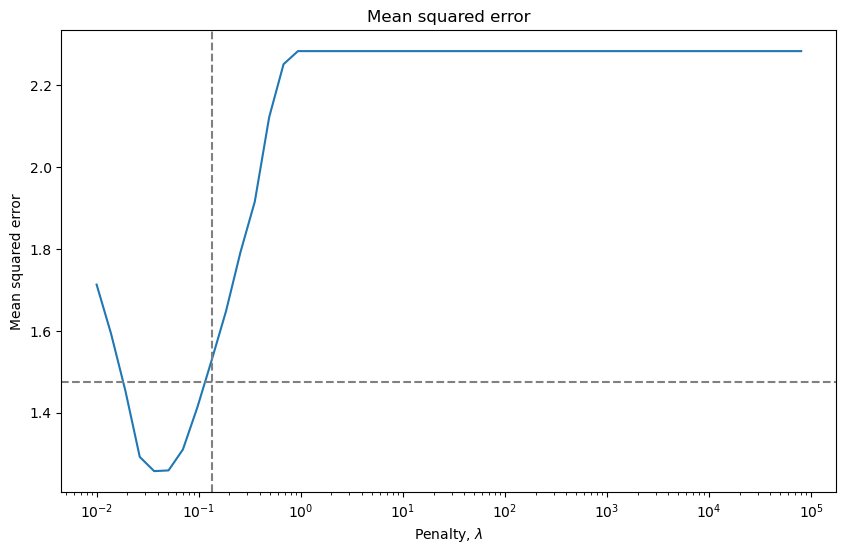

In [89]:
# Define a function that plots the MSE as a function of the penalty parameter

def plot_MSE_path(penalty_grid, MSE, MSE_SE, penalty):

    # Initiate figure

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot coefficients as a function of the penalty parameter


    plt.plot(penalty_grid, MSE)

    # Set log scale for the x-axis

    plt.xscale("log") 

    # Plot minimum MSE

    min_MSE_idx = np.argmin(MSE)

    min_MSE_penalty = penalty_grid[min_MSE_idx]

   # ax.axvline(x=min_MSE_penalty, linestyle='--', color='grey')

    #lt.text(penalty_CV,1e10,"Minimum MSE",rotation=90)

    new = MSE[min_MSE_idx]+MSE_SE

    ax.axhline(y = new, linestyle = "--", color = "grey")

    ax.axvline(x = penalty, linestyle='--', color='grey')   

    # Add labels

    plt.xlabel('Penalty, $\lambda$')

    plt.ylabel('Mean squared error')

    plt.title('Mean squared error')

 

    # Display plot

    plt.show()

    plt.close()

 

# Plot MSE as a function of the penalty parameter

plot_MSE_path(penalties_CV, MSE_CV, min_MSE_SE, lamb1)

# Here with 1 std.error rule